# Refinitiv Academic Article Series:

# Predicting M&A Targets Using Machine Learning Techniques

## Table of Content
1. [Theoretical Background](#Section-1:-Theoretical-Background)<br>
    1.1 [Definitions to M&A](#1.1-Definitions-to-M&A)<br>
    1.2 [Background to M&A](#1.2-Background-to-M&A)<br>
2. [Methodology](#Section-2:-Methodology)<br>
    2.1 [Methodology of the predictive model](#2.1-Methodology-of-the-predictive-model)<br>
    2.2 [Methodology for portfolio abnormal returns estimation](#2.2-Methodology-for-portfolio-abnormal-returns-estimation)<br>
3. [Data description](#Section-3:-Data-description)<br>
    3.1 [Dataset for Target companies](#3.1-Dataset-for-Target-companies)<br>
    3.2 [Dataset for non-Target companies](#3.2-Dataset-for-non-Target-companies)<br>
4. [Empirical results](#Section-4:-Empirical-results)<br>
    4.1 [Variables selection](#4.1-Variables-selection)<br>
    4.2 [Results from Logistic regression models](#4.2-Results-from-Logistic-regression-models)<br>
    &emsp;4.2.1 [Model on the entire dataset](#4.2.1-Model-on-the-entire-dataset)<br>
    &emsp;4.2.2 [Model on the clustered dataset](#4.2.2-Model-on-the-clustered-dataset)<br>
    &emsp;4.2.3 [Comparison of unclustered and clustered results: The effect of clustering](#4.2.3-Comparison-of-unclustered-and-clustered-results:-The-effect-of-clustering)<br>
5. [Out of sample predictive power of the model](#Section-5:-Out-of-sample-predictive-power-of-the-model)<br>
    5.1 [Identification of optimal cut-off probability](#5.1-Identification-of-optimal-cut-off-probability)<br>
    5.2 [Classification results on the holdout sample](#5.2-Classification-results-on-the-holdout-sample)<br>
    &emsp;5.2.1 [Results from the model on the entire dataset](#5.2.1-Results-from-the-model-on-the-entire-dataset)<br>
    &emsp;5.2.2 [Results from the models on seperate clusters](#5.2.2-Results-from-the-models-on-seperate-clusters)<br>
6. [Portfolio returns](#Section-6:Portfolio-returns)<br>
    6.1 [Announcement returns](#6.1-Announcement-returns)<br>
    6.2 [Portfolio returns](#6.2-Portfolio-returns)<br>
    &emsp;6.2.1 [Portfolio abnormal returns](#6.2.1-Portfolio-abnormal-returns)<br>
    &emsp;6.2.2 [Portfolio investment returns](#6.2.2-Portfolio-investment-returns)<br>
7. [Conclusion](#Section-7:Conclusion)<br>

The purpose of this article is to build a predictive model for Mergers and Acquisitions (M&A) target identification and discover if that will produce an abnormal return for investors by utilizing Refinitiv Data APIs. Extensive literature review is conducted to identify main Machine Learning models as well as variables used in empirical studies which can be provided by individual request. The rest of the article is structured in the following way. **Section 1** briefly provides theoretical background to M&A, discusses the main motivations and drivers, and suggests main stakeholders who can benefit from target predictive modeling. **Section 2** and **Section 3** present the methodology of predictive modeling and describe the data respectively. **Section 4** discusses the empirical results from logistic regression models and identifies significant variables. We test out-of sample predictive power of the models in **Section 5**. **Section 6** provides portfolio return estimations based on the prediction outputs.

Below are three code cells containing packages required in this report. If these packages are not already installed on your computer, please run these cells.

In [ ]:
!pip install eikon 

In [ ]:
!pip install sklearn

In [ ]:
!pip install plotnine

In [ ]:
!pip install seaborn

In [ ]:
!pip install openpyxl

We need also to imprt the following packages:

In [5]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import plotnine as pn
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

# import eikon package and read app key from a text file
import eikon as ek
app_key = open("app_key.txt","r")
ek.set_app_key(app_key.read())
app_key.close()

## Section 1: Theoretical Background

### 1.1 Definitions to M&A

M&A are corporate actions involving restructuring and change of control within companies, which play an essential role in external corporate growth. The literature uses the terms of mergers, acquisitions, and takeovers synonymously; however, there are subtle differences in their economic implications. Piesse, Lee, Lin, and Kuo (2013) interpret acquisitions and takeovers as activities when the acquirer gets control over 50% equity of the target company and mergers when two firms join to form a new entity.

Overall, according to Piesse et al. (2013), the negotiating process is often friendly in M&A, assuming synergies for both firms and hostile in case of takeovers. In this sense, terms “merger” and “acquisition” are used synonymously to refer to friendly corporate actions and “takeovers” to hostile corporate actions. The current article concentrates on friendly M&A only, which assumes a substantial premium for the target’s stock price.

### 1.2 Background to M&A

M&A activity has increased throughout recent years both in terms of the number and value of the deals. The number of M&A deals reached its peak in 2017 when 50,600 M&A deals were announced, totaling USD 3.5 trillion. The activity was more than twenty times higher than the number of deals in 1985 and around ten times higher than the deal value for the same year. M&A activity for 1985-2021 is summarized in Figure below ([Source](https://imaa-institute.org/mergers-and-acquisitions-statistics/)):
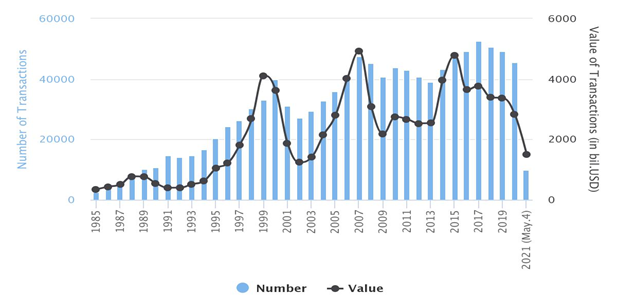

M&A activity is evolving in cycles that coincide with the economic rise and major shocks, such as the IT bubble in the 2000s, the financial crisis in 2007-2009, and recent economic movements caused by COVID-19. These tendencies are well researched in academic literature and are referred to as merger waves (Martynova & Renneboog, 2006). Mitchell and Mulherin (1996) claim that M&A activity is driven by industry and macroeconomic shocks, which trigger the start or end of M&A activity waves triggered by regulatory, economic, or technological shocks and innovations.

### 1.3 Main stakeholders of M&A prediction modeling

Tunyi (2021) suggests three stakeholders interested in predicting M&A targets:

**Investors** - Corporate events, such as M&A or bankruptcy announcements, result in substantial stock price changes, thus allowing investors to receive abnormal returns. Previous research reports significant abnormal returns for target companies. For example, Jensen and Ruback (1983) claim 29.1% weighted average abnormal return for target companies in the US in the two months around the M&A announcement. 

**Company managers** - Prior academic literature considers management inefficiency one of the main factors of a company’s acquisition. Thus, knowledge of anticipated takeover allows taking the necessary actions to safeguard shareholder interests by setting up takeover defense strategies (Tunyi, 2021). Those strategies may make the takeover deal unattractive or allow the managers and target company shareholders to generate excess returns (Schwert, 2000). Additionally, information on the probability of the company’s partners’ and competitors’ engagement in M&A could be helpful in the company’s strategy development (Tunyi, 2021).

**Regulators** An essential role of securities market regulators is to identify and exclude insider trading. Keown and Pinkerton (1981) mention that many individuals and groups, such as bankers, advisers who are engaged in M&A, hold non-public price-sensitive information, which is poorly kept secret. Several researchers (Schwert, 1996; Goergen & Renneboog, 2004) identify stock price run-ups from two to four months before announcing the M&A. While Jensen and Ruback (1983) explain that by market anticipation, Keown and Pinkerton (1981), Schwert (1996) attribute it to insider trading. A practical tool allowing regulators to investigate the extent of market anticipation of takeover based on public information could help them make informed decisions on market abuse

## Section 2: Methodology

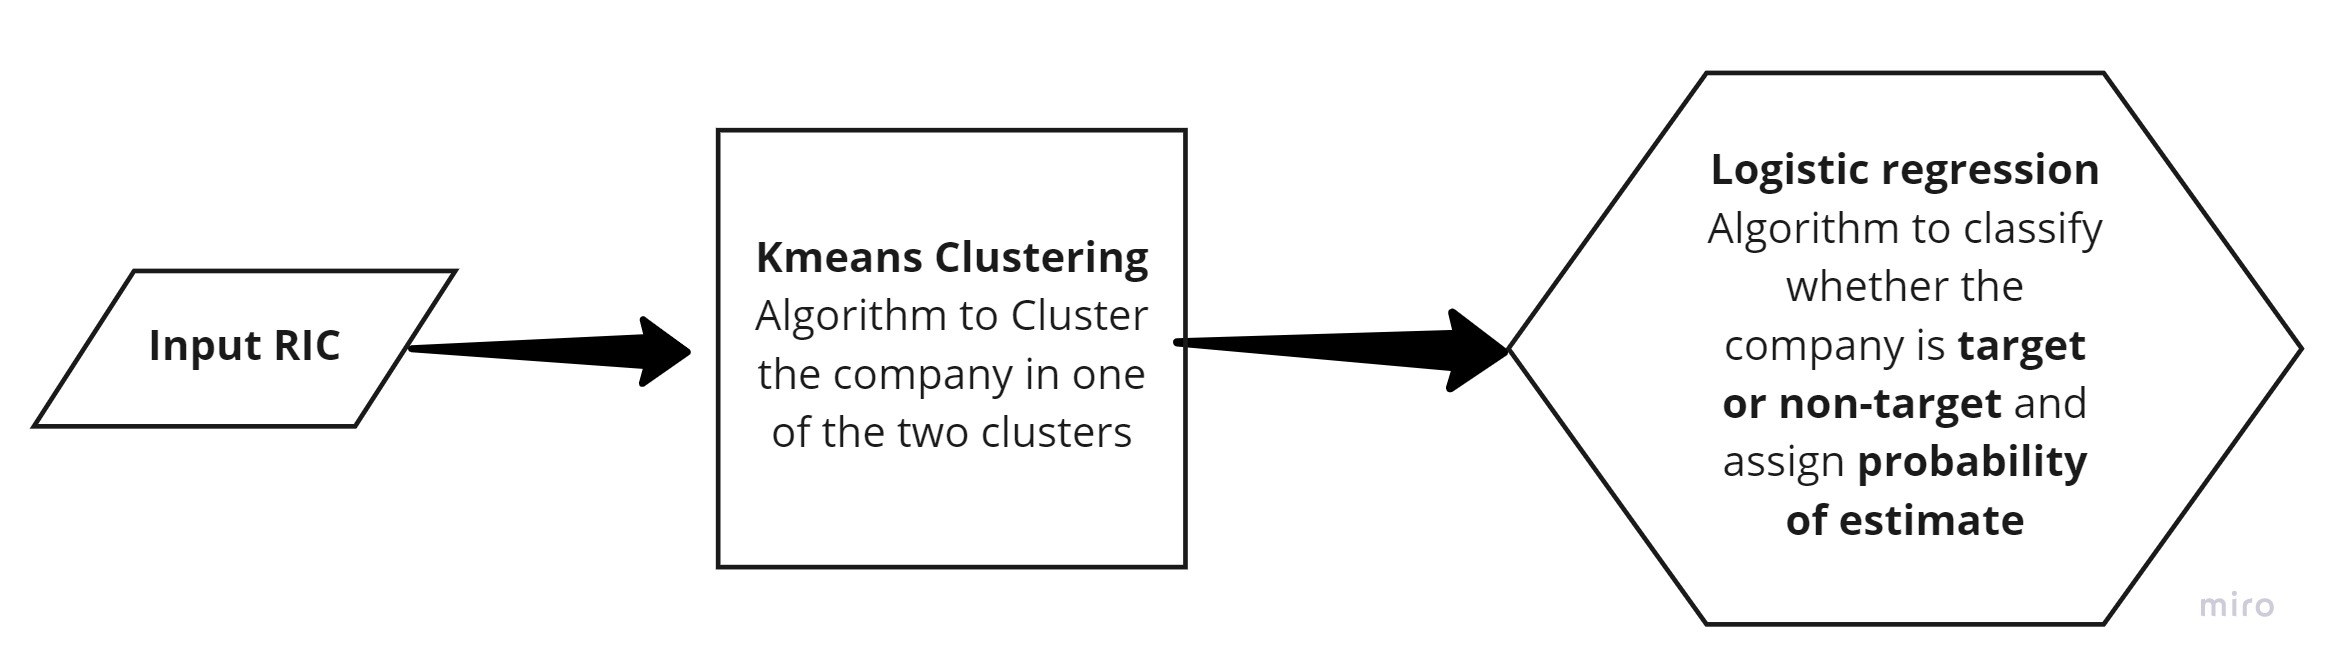

Researchers used various empirical techniques for target identification, including parametric, linear discriminant analysis, conditional and logistical regression, and non-parametric techniques, such as SVM, Neural Networks, and Utilities Additive Discriminants. Despite the wide range of methodologies, logistic regression was proven to be the most prevailing due to higher classification accuracy and the explainability of the outputs. We have also tested different methodologies, including SVM, Decision tree, Random forest algorithms and identify that logistic regression generalizes better and provides higher accuracy and explainability.

Thus, in line with most previous empirical studies, the current article uses logistic regression to classify target and non-target companies.Intermediate clustering of sample data is employed to test whether prediction accuracy and abnormal returns will increase.

**Logistic Regression:** The study uses binary logistic regression and is conducted in Python using the sklearn package with a liblinear solver and penalty of l2 (ridge regression). The model equation is given as follows:

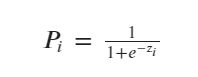


${P}_{i}$ is the probability of company ${i}$ being a target, and ${Z}_{i}$ is the vector of the company ${i}$ characteristics given as the following:

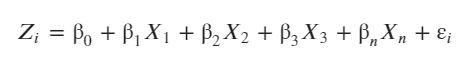

where ${β_0}$ is the intercept and ${β_j}$(${j}$ = 1,…,${k}$) is the coefficient of respective independent variable ${X_j}$ (j = 1,…,k) for each company. The dependent dummy variable equals to 1 if the company is a target and 0 otherwise. It is worth highlighting that all the variables are sourced as of 1 month before the announcement, both for target and non-target groups. Non-targets are matched with targets as of the announcement date of the corresponding target acquisition.

To identify the optimal variables to include in the logistic regression model and avoid multicollinearity, correlation analysis, t-test for the mean difference, and Variance Inflation Factor (VIF) test are used. First, correlation analysis was done to identify the interdependence of the variables and potential multicollinearity. One of the correlated variables was eliminated based on its significance in the t-test and VIF score.

**Clustering:** Further, we propose a clustering technique to test if that increases the accuracy of logistic regression outputs and portfolio returns. We compared prediction outputs and portfolio returns between logistic regression models estimated on the entire and clustered datasets to test this. We started by estimating logistic regression on the entire dataset. Then, we clustered the entire dataset into two groups and evaluated logistic regression models on each cluster separately. Finally, we compared results from models based on the entire dataset and each cluster dataset. Additionally, combined clustered outputs were compared with the results from the entire dataset.

The clustering is done based on liquidity and leverage variables of target and non-target companies, which are the same as in logistic regression. The study uses the Kmeans clustering technique conducted in a Python environment using the sklearn package.

The algorithm is an iterative process aimed to partition data into prespecified groups to minimize the sum of the squared distance (Euclidean distance in our case) between the data points and the cluster centroid (Hastie, Tibshirani, & Friedman,2009).The algorithm aims to minimize the following equation:

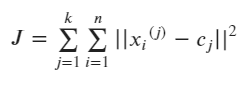

where ${j}$ is the number of clusters, which is 2 in our case, ${i}$ is the number of sample companies ${x_i}^{(j)}$ is the company ${i}$ for cluster ${j}$ and ${c_j}$ is the centroid for cluster ${j}$.


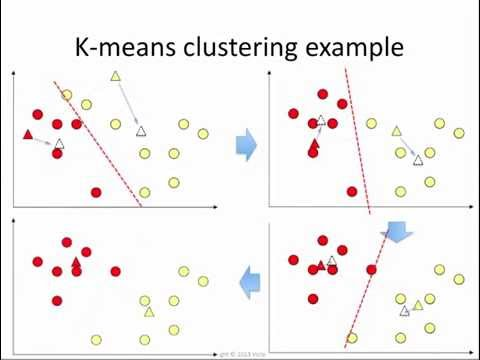

Source:https://www.youtube.com/watch?v=_aWzGGNrcic

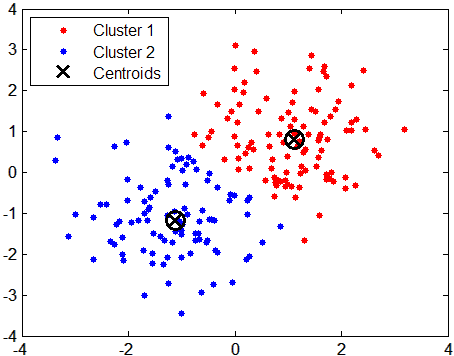

Image source:https://iambecomecomputational.com/2018/06/22/computational-plant-science-clustering-in-r-tutorial/

### 2.2 Methodology for portfolio abnormal returns estimation

***Portfolio construction Strategies***

To estimate the practical usefulness of the target prediction model an optimal cut-off based on the maximization of the difference between True Positive Rate (TPR) and False Positive Rate (FPR) is used to classify target and non-target companies.

Then, portfolio abnormal returns for an observation period of 60 days before and 3 days after the announcement for all predicted target companies are calculated. Additionally, an investment strategy of buying all predicted targets during the beginning of the year and selling right after the announcement (false predicted targets are kept in the portfolio until the end of the observation period) is employed. The portfolio investment return is compared with Standard & Poor’s (S&P) 500 return for the same period to identify whether the portfolio constructed from all predicted targets can generate market excess return.

***Calculation of abnormal returns***

Abnormal returns are calculated by using event study methodology (MacKinlay,1997) using the following equation.

<!-- <font size="3">  $$ \begin{array}{ll}
{AR}_{i,t} = {r_{i,t}} - {(α_i + β_i R_{m,t})}
\end{array}$$
</font> -->

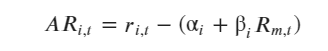

where ${r_{i,t}}$ is the return on security ${i}$ in period ${t}$, ${R_{m,t}}$ is the market return in period ${t}$. ${α}$ and ${β}$ are model parameters. ${α}$  is a constant that assumed zero; ${β}$  is calculated by regressing stock returns against the market returns and shows stock returns volatility versus the market returns.

The methodology assumes an estimation period when model parameters, such as ${β}$  is estimated and an observation period for which the actual returns are calculated. ${β}$  is calculated for the estimation period by regressing daily stock returns against the S&P 500 index as a market return proxy. Further, to calculate Cumulative Abnormal Return (CAR), abnormal returns of each stock are summed for the whole observation period:

<!-- <font size="3">  $$ \begin{array}{ll}
{CAR}_{(t_1,t_2)} = \sum \limits_{t=t_1} ^ {t_2} {AR_{it}}
\end{array}$$
</font>
 -->
 
 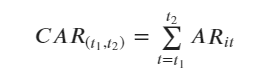
 
where, ${t_1}$,${t_2}$ denote the start and the end of the observation period. 

The following function calculates abnormal return of a given security during an observation period based on Event study Methodology(MacKinlay,1997).

In [6]:
def ab_return(RIC, sdate, edate, announce_date, period):
    '''
    Calculate abnormal return of a given security during an observation period based on Event study Methodology(MacKinlay,1997)
    
    Dependencies
    ------------
    Python library 'eikon' version 1.1.12
    Python library 'numpy' version 1.20.1
    Python library 'pandas' version 1.2.4
    Python library 'Sklearn' version 0.24.1
    
    Parameters
    -----------
        Input:
            RIC (str): Refinitiv Identification Number (RIC) of a stock
            sdate (str): Starting date of the estimation period - in yyyy-mm-dd
            edate (str): End date of the estimation period, which is also starting date of the observation period - in yyyy-mm-dd
            announce_date (str): End date of the observation period which is assumed to be the M&A announcment date or any other specified date
            period (int): Number of trading days in during the observation period. For each date in this period abnormal return is calculated
        Output:
            CAR (int): Cumulative Abnormal Return (CAR) for a given stock
            abnormal_returns (DataFrame): Dataframe containing abnormal returns during the observation period
    '''
    
    #create an empty dataframe to store abnormal returns
    abnormal_returns = pd.DataFrame({'#': np.arange(start = 1, stop = period)})
    
    ## estimate linear regression model parameters based on estimation period
    # get timeseries for the specified RIC and market proxy (S&P 500 in our case) for the both estimation and observation period
    df_all_per = ek.get_timeseries([RIC, '.SPX'], 
                      start_date = sdate, 
                      end_date = announce_date,
                      interval='daily',
                      fields = 'CLOSE')
    
    # slice the estimation period
    df_all_per.reset_index(inplace = True)
    df_est_per = df_all_per.loc[(df_all_per['Date'] <= edate)]
    
    # calculate means of percentage change of returns for the stock and market proxy
    df_est_per.insert(loc = len(df_est_per.columns), column = "Return_stock", value = df_est_per[RIC].pct_change()*100)
    df_est_per.insert(loc = len(df_est_per.columns), column = "Return_market", value = df_est_per[".SPX"].pct_change()*100)
    mean_stock = df_est_per["Return_stock"].mean()
    mean_index = df_est_per["Return_market"].mean()
    df_est_per.dropna(inplace = True)
    
    # reshape the dataframe and estimate parameters of linear regression
    y = df_est_per["Return_stock"].to_numpy().reshape(-1,1)
    X = df_est_per["Return_market"].to_numpy().reshape(-1,1)
    model = LinearRegression().fit(X,y)
    Beta = model.coef_[0][0]
    intercept = model.intercept_[0]
    
    # slice the estimation period
    df_obs_per = df_all_per.loc[(df_all_per['Date'] >= edate)]
    
    # calculate percentage change of returns for the stock and market proxy
    df_obs_per.insert(loc = len(df_obs_per.columns), column = "Return_stock", value = df_obs_per[RIC].pct_change()*100)
    df_obs_per.insert(loc = len(df_obs_per.columns), column = "Return_market", value = df_obs_per[".SPX"].pct_change()*100)
    
    df_obs_per.dropna(inplace=True)
    df_obs_per.reset_index(inplace=True)
    
    # calculate and return cumulative abnormal return (CAR) for the observation period
    abnormal_returns.insert(loc = len(abnormal_returns.columns), column = str(RIC)+'_Date', value = df_obs_per["Date"])
    abnormal_returns.dropna(inplace=True)
    abnormal_returns.insert(loc = len(abnormal_returns.columns), column = str(RIC)+'_return', value = df_obs_per["Return_stock"] - (intercept + Beta * df_obs_per["Return_market"]))
    CAR =  abnormal_returns.iloc[:,2].sum()
    return CAR, abnormal_returns

The following gives an example of calculaing abnormal return for Slack Technologies (WORK.N^G21) during the observation period which includes the aquisition announcement date by Salesforce.

In [9]:
CAR, abnormal_returns = ab_return("WORK.N^G21", '2020-03-26', "2020-10-02", "2020-12-01", 60)
print(CAR)

50.620286227582014


In [ ]:
abnormal_returns

The function mentioned above has been used to calculate abnormal returns for 3 different cases:

**1. Calculate Run-up return vriable for target and non-target companies** - This variable is based on the findings in the previous literature (Keown & Pinkerton, 1981, Barnes, 1998), suggesting that target companies generate significant run-up returns during one to two months before the announcement of the deal. We calculate this return for both target and non-target companies.The period 250 to 60 days before the deal announcement was used as an estimation window. The observation period was two months before the announcement.

**2. Calculate post announcement abnormal returns** - In order to support the assumption that shareholders of target companies receive abnormal returns after company acquisition post-announcement abnormal returns for target companies are calculated.

**3. Calculate portfolio abnormal returns** - abnormal returns for the portfolios, constructed based on the models outputs are calculated to test whether a target prediction model can capture some of the examined announcement abnormal returns.

The estimation window for both the announcement and portfolio returns is 250 to 60 days before the deal announcement. The observation period for portfolio abnormal return calculation is 60 days before and 3 days after the announcement. As for the announcement returns, multiple observation periods, such as [-40, +40], [-20, +20], [-10, +10], [-5, +5], are considered to observe both run-up (two months preceding the announcement) and mark-up returns (two months following the deal announcement). The Figure below illustrates observation and estimation periods of both announcement and portfolio abnormal returns.
 
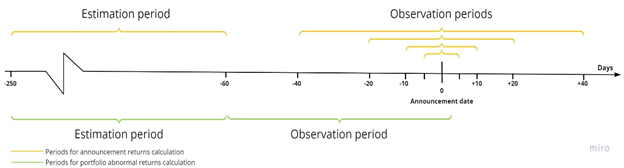

## Section 3: Data description

To build a logistic regression model for target prediction a dataset of target and non-target companies is required. Two separate datasets for each group of companies is retrieved from Refinitiv and then merged into single one with appropriate labels to estimate a Logistic regression model.

### 3.1 Dataset for Target companies

The target sample is constructed based on M&A Advanced Search section of Refinitiv Workspace to include relevant deals for target companies in the US. The screen shot below shows the filters used to get the relevant data for the article.
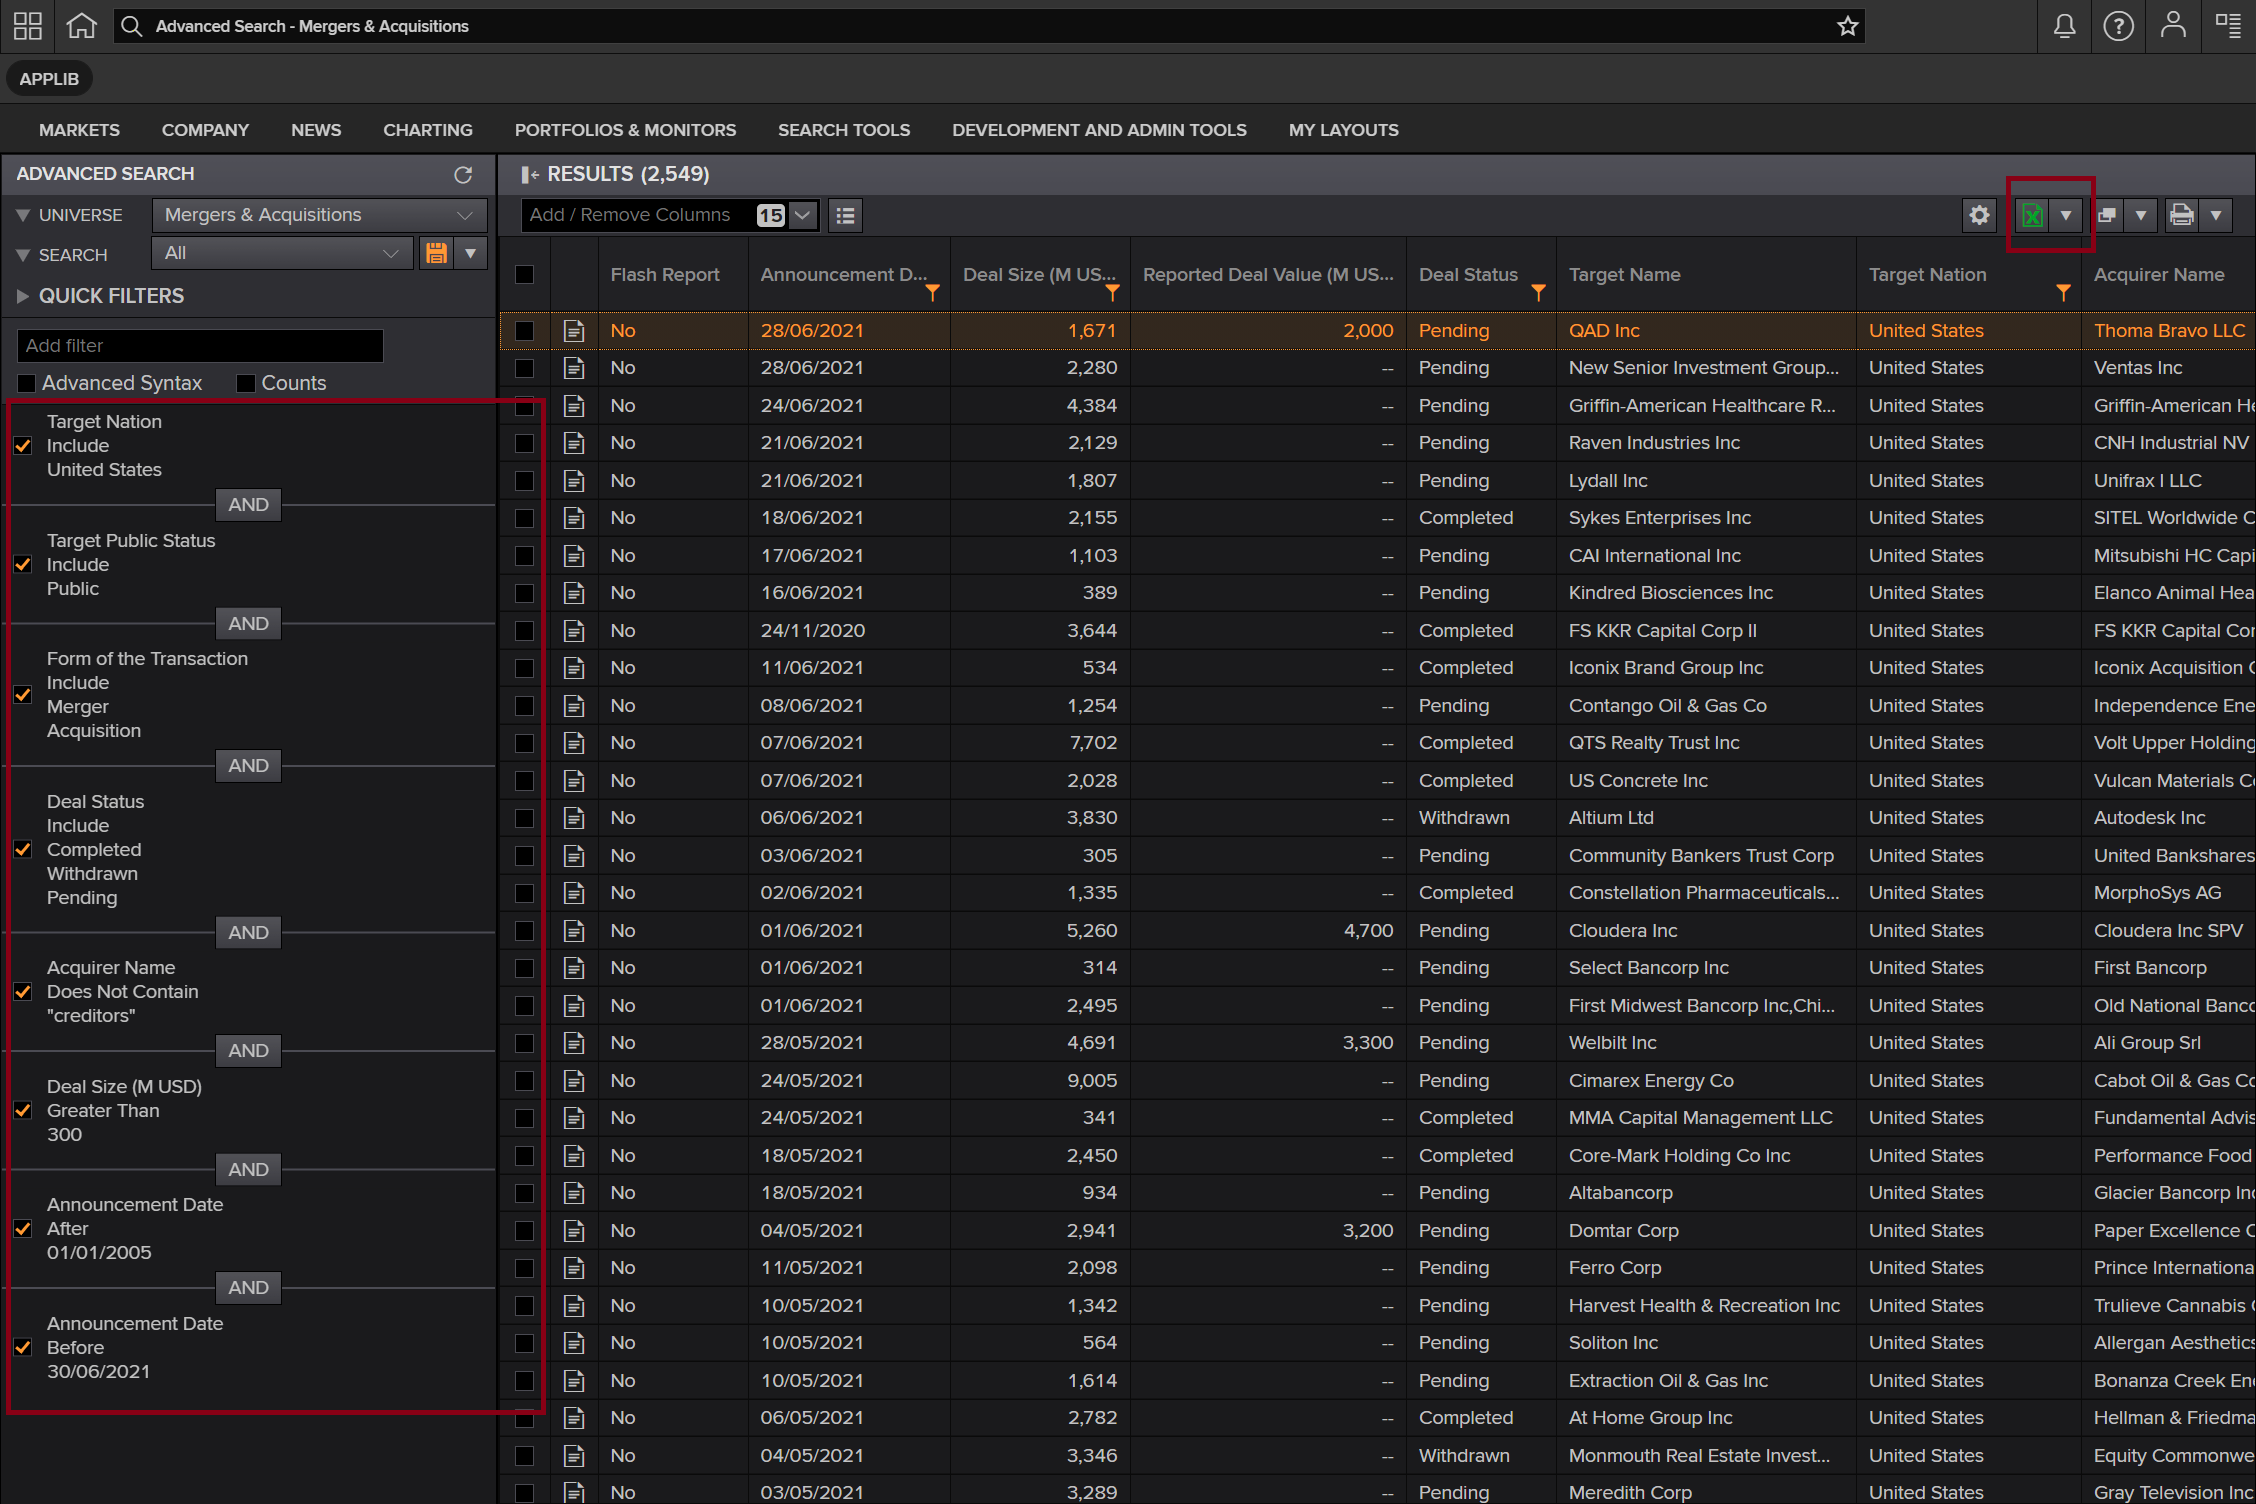

The retrieved data consisted of 2549 target companies from the US. Further screening for data availability of selected variables (1547 observations eliminated), peers (254 observations eliminated), and removal of outliers (92 observations eliminated) resulted in a final dataset of 656 target companies for announcement date from April 2010 – June 2021. The final dataset for target companies is included in the [github folder](https://github.com/Refinitiv-API-Samples/Article.EikonAPI.Python.PredictionOfMandATargetsToGenerateAbnormalReturns/tree/main/Datasets) of the current article. As the data were retrieved in excel from the Advanced Search directly we retrieve variable values directly in excel using **Refinitiv Add-in formulas**.

The following code reads the target dataset into a dataframe.

In [5]:
#read target group dataset from excel file: update URL based on your file location
target_group = pd.read_excel (r'Target_Sample.xlsx')

#select only the columns needed for the subsequect sections 
target_group = target_group.iloc[:,3:31]
target_group.head()

,AD-30,Announcement Date,Company RIC,Market Cap,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
0,2021-05-29,2021-06-28,QADA.O,1.278517e+09,-9.775437,10.774550,4.201914,59.18308,0.077847,4.544522,...,4.807378,4.129297,11.428748,0.097879,0.996802,1.002554,-6.270184,-0.91340,1,1
1,2021-05-22,2021-06-21,RAVN.O,1.157002e+09,-7.701835,7.449319,6.531071,33.81626,0.056500,7.288653,...,4.424246,4.337533,4.644855,0.008242,0.180739,0.098591,-0.842171,-0.09042,1,1
2,2021-05-22,2021-06-21,LDL,5.325349e+08,-11.843083,-4.713130,-1.555628,18.96168,-0.139595,2.823379,...,0.813417,1.031316,2.430913,1.049446,32.008828,0.193466,9.432784,0.31860,1,1
3,2021-05-19,2021-06-18,SYKE.OQ^H21,1.490433e+09,-11.146474,7.669254,3.841362,32.09241,0.058989,7.491430,...,0.931876,0.895016,1.780169,0.070497,3.052414,0.107747,-1.440183,-0.05943,0,1
4,2021-05-09,2021-06-08,MCF,3.977447e+08,-9.647523,-251.266270,-146.447928,8.89214,-5.337401,-20.078817,...,7.253047,7.377276,45.870267,0.989979,1.849967,0.044645,0.080742,0.45284,0,1


In [10]:
target_group.describe()

,Market Cap,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,ROC,EV/EBIDTA,"Sales growth, 3y",Free cash Flow/Sales,...,Working Capital to Total Assests,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch
count,6.560000e+02,656.000000,656.000000,656.000000,655.000000,656.000000,656.000000,656.000000,656.000000,656.000000,...,655.000000,6.560000e+02,656.000000,656.000000,656.000000,656.000000,655.000000,656.000000,656.000000,656.000000
mean,4.045851e+09,1.227193,0.004292,42.592205,0.011263,8.386456,7.239450,10.709083,16.277893,-0.005295,...,0.192846,2.566303e+00,3.179511,4.055075,1.278185,26.890114,0.174700,9.272178,0.160276,0.317073
std,8.610801e+09,51.640629,33.771662,21.314522,0.264163,20.842951,13.043522,59.782520,55.207696,0.453567,...,0.210179,2.742320e+00,3.113478,6.783922,3.441966,22.710054,0.223336,15.630188,0.472660,0.465691
min,1.141077e+07,-764.000937,-256.188448,0.565030,-5.337401,-245.919660,-72.692063,-864.301773,-25.870643,-6.586436,...,-0.671050,8.000000e-09,0.095067,-1.557987,-35.141609,0.000000,0.000072,-23.837710,-2.622780,0.000000
25%,5.949042e+08,-1.868845,-1.386343,26.123918,-0.008542,2.897525,3.257199,7.013958,0.924596,-0.010343,...,0.027840,8.142326e-01,1.163568,1.604212,0.154095,6.051583,0.029994,-0.964812,-0.122802,0.000000
50%,1.415345e+09,6.999636,3.864721,41.146985,0.039185,8.911569,7.353025,10.612786,7.095638,0.051043,...,0.157720,1.741472e+00,2.235609,2.447625,0.738462,24.968875,0.099197,5.778312,0.295490,0.000000
75%,3.940691e+09,14.453616,9.865902,57.789120,0.088947,17.107852,12.727209,16.922002,17.110155,0.115698,...,0.308820,3.325394e+00,3.874402,4.047843,1.325697,42.010874,0.232926,15.229821,0.514080,1.000000
max,1.048407e+11,246.345515,205.474778,99.235790,0.536342,59.360426,59.537746,440.269908,976.508129,0.661562,...,0.862140,2.699586e+01,19.028140,103.528200,41.333135,131.325927,2.622785,166.992527,1.178030,1.000000


### 3.2 Dataset for non-Target companies

The non-target sample was constructed from companies similar to target companies first, in terms of business activity, and second, size as measured by market capitalization at the time of the bid. To identify the non-target control group, Refinitiv **peers SCREEN**  is used. The Peer group for each company and the variables to be used in the prediction model are retrieved using the function in the cell below.

In [40]:
def peers(RIC, date):
    '''
    Get peer group for an individual RIC along with required variables for the models
    Dependencies
    ------------
    Python library 'eikon' version 1.1.12
    Python library 'pandas' version 1.2.4    
    Parameters
    -----------
        Input:
            RIC (str): Refinitiv Identification Number (RIC) of a stock
            date (str): Date as of which peer group and variables are requested - in yyyy-mm-dd
        Output:
            peer_group (DataFrame): Dataframe of 50 peer companies along with requested variables
    
    '''
    # specify variables for the request
    fields=["TR.TRBCIndustry", "TR.TRBCBusinessSector", "TR.TRBCActivity", "TR.F.MktCap", "TR.F.ReturnAvgTotEqPctTTM",
           "TR.F.IncAftTaxMargPctTTM","TR.F.GrossProfMarg","TR.F.NetIncAfterMinIntr","TR.F.TotCap","TR.F.OpMargPctTTM",
           "TR.F.ReturnCapEmployedPctTTM","TR.F.NetCashFlowOp", "TR.F.LeveredFOCF", "TR.F.TotRevenue", "TR.F.RevGoodsSrvc3YrCAGR",
           "TR.F.NetPPEPctofTotAssets", "TR.F.TotAssets","TR.F.SGA","TR.F.CurrRatio","TR.F.WkgCaptoTotAssets",
           "TR.PriceToBVPerShare","TR.PriceToSalesPerShare","TR.EVToEBITDA","TR.EVToSales","TR.F.TotShHoldEq","TR.F.TotDebtPctofTotAssets",
           "TR.F.DebtTot","TR.F.NetDebtPctofNetBookValue","TR.F.NetDebttoTotCap","TR.TotalDebtToEV","TR.F.NetDebtPerShr","TR.TotalDebtToEBITDA"]
    
    #search for peers
    instruments = 'SCREEN(U(IN(Peers("{}"))))'.format(RIC)
    
    #request variable data for each peer
    peer_group, error = ek.get_data(instruments = instruments, fields = fields, parameters = {'SDate': date})
    
#     df.to_excel(str(RIC[i]) + '.xlsx') - can be enabled if required to store peer data in excel

    return peer_group

The following gives an example of retrieving peers and specified variables for Slack Technologies. The next cell provides the list of target company RICs along with the date for peer identification and variable retrieval.

In [491]:
#request peer data for Slack and show first 5 peers 
peers('WORK.N^G21', '2020-11-01').head()

,Instrument,TRBC Industry Name,TRBC Business Sector Name,TRBC Activity Name,Market Capitalization,"Return on Average Total Equity - %, TTM","Income after Tax Margin - %, TTM",Gross Profit Margin - %,Net Income after Minority Interest,Total Capital,...,Enterprise Value To EBITDA (Daily Time Series Ratio),Enterprise Value To Sales (Daily Time Series Ratio),Total Shareholders' Equity incl Minority Intr & Hybrid Debt,Total Debt Percentage of Total Assets,Debt - Total,Net Debt Percentage of Net Book Value,Net Debt to Total Capital,Total Debt To Enterprise Value (Daily Time Series Ratio),Net Debt per Share,Total Debt To EBITDA (Daily Time Series Ratio)
0,CRM.N,IT Services & Consulting,Software & IT Services,Cloud Computing Services,161708970000.0,8.53505,12.244582,75.23102,126000000.0,36947000000.0,...,75.667295,10.56531,33885000000.0,5.55455,3062000000.0,-16.84483,-0.13222,1.305458,-5.470325,0.987805
1,TEAM.OQ,Software,Software & IT Services,Software (NEC),44700285863.790001,-63.864982,-25.815988,83.34708,-350654000.0,1729057000.0,...,348.861618,27.320632,575306000.0,29.62839,1153751000.0,<NA>,-0.57558,2.479368,-4.021923,8.649564
2,SPLK.OQ,Software,Software & IT Services,Software (NEC),24215811838.68,-41.714537,-27.622625,81.78035,-336668000.0,3714059000.0,...,<NA>,13.637515,1999429000.0,31.522,1714630000.0,-2.06907,-0.01091,7.035879,-0.256871,<NA>
3,NOW.N,Software,Software & IT Services,Enterprise Software,53245552000.0,34.148025,16.597748,76.97849,626698000.0,2822922000.0,...,179.616716,22.703498,2127941000.0,11.53988,694981000.0,-88.00939,-0.35287,1.779752,-5.25762,3.196732
4,MSFT.OQ,Software,Software & IT Services,Software (NEC),1543305924666.969971,41.399328,32.285167,67.781,44281000000.0,191127000000.0,...,21.371859,9.968566,118304000000.0,24.16872,72823000000.0,-116.67399,-0.33331,5.026813,-8.414212,1.074323


In [494]:
# retrieve RICs and dates for target group companies
RICs = target_group['Company RIC'].to_list()
date = target_group['AD-30'].dt.strftime('%Y-%m-%d').to_list()

Running "peer" function over all RICs and dates above will create dataframes (or excel files) for each target company, which will include all peers along with specified variables. After screening the peer data based on their similarity to the target group and data availability, each target was matched by year with the closest non-target company.The final dataset for non-target companies is included in the [github folder](https://github.com/Refinitiv-API-Samples/Article.EikonAPI.Python.PredictionOfMandATargetsToGenerateAbnormalReturns/tree/main/Datasets) of the current article.

In [6]:
non_target_group = pd.read_excel (r'Non-target_sample.xlsx')
non_target_group = non_target_group.iloc[:,4:31]

non_target_group.head()

,Announcement Date,Company RIC,Market Cap,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,Return on Capital,...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
0,2021-06-28,OPRA.OQ,1.042124e+09,-2.831319,6.083762,65.461049,83.82711,0.169373,15.307199,1.394860,...,7.262251,6.548395,1.296834,0.008555,0.735752,0.126564,-1.101874,-0.11889,0,0
1,2021-06-21,BDGI.TO,1.325491e+09,-7.522057,1.435150,0.894579,15.33098,0.052053,1.954500,1.837000,...,2.575443,2.793027,4.468704,0.447268,8.701365,0.036376,3.719562,0.27267,0,0
2,2021-06-21,LXFR.N,4.537856e+08,-4.183324,12.733008,6.934080,24.90764,0.090703,11.847015,12.007564,...,1.998172,2.126281,3.635942,0.319569,10.675449,0.006803,1.789655,0.23537,1,0
3,2021-06-18,CSGS.OQ,1.484872e+09,-1.351786,13.953294,5.693989,43.61389,0.075892,10.941099,13.942270,...,1.472389,1.617140,3.443384,0.831489,21.661849,0.243919,3.390701,0.14338,1,0
4,2021-06-08,NOG.A,4.021609e+08,22.048509,-329.504482,-388.580768,4.88476,-1.255706,15.533732,4.011939,...,1.826714,3.535152,-3.433331,-4.231196,48.400209,0.001979,20.549773,1.30750,0,0


In [496]:
non_target_group.describe()

,Market Cap,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,Return on Capital,EV to EBIDTA,"Sales growth, 3y",...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
count,6.560000e+02,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,...,6.560000e+02,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.0
mean,4.327800e+09,-0.038345,5.461099,3.032561,42.118377,0.045924,9.690908,9.461485,13.039091,18.259026,...,3.055401e+00,3.688036,3.903870,1.040082,23.001527,0.168167,9.464655,0.111950,0.335366,0.0
std,9.398950e+09,17.679145,37.755866,29.400388,22.057620,0.161203,22.559521,14.183948,71.461098,54.845167,...,3.980272e+00,4.877811,9.202817,2.782451,21.691624,0.192020,32.388579,0.431660,0.472478,0.0
min,9.151093e+06,-126.719136,-456.588400,-388.580768,-13.237920,-1.255706,-263.836139,-71.071607,-801.846864,-27.366157,...,6.400000e-08,0.097714,-57.427528,-4.231196,0.000000,0.000000,-155.537465,-1.580580,0.000000,0.0
25%,6.388626e+08,-8.067319,1.434235,1.063125,24.764202,0.007688,4.223528,4.037114,7.515283,1.190327,...,7.728638e-01,1.062764,1.450024,0.108651,4.598596,0.031875,-1.473642,-0.187713,0.000000,0.0
50%,1.585328e+09,0.176899,8.971992,5.342759,40.226225,0.053812,9.181608,8.680717,11.160644,7.887975,...,1.661098e+00,2.087322,2.408813,0.538702,18.370209,0.103290,2.629143,0.188925,0.000000,0.0
75%,4.091758e+09,8.888801,16.612105,10.672193,57.440215,0.101982,17.323043,15.174641,18.007269,18.298586,...,3.791393e+00,4.291080,4.139631,1.054455,35.620913,0.241191,12.279559,0.438397,1.000000,0.0
max,9.358111e+10,135.373180,157.679506,100.854473,100.000000,0.969145,85.147018,115.929048,689.333074,879.866524,...,4.181935e+01,65.161869,183.226869,47.826708,127.442849,1.601634,435.709493,1.307500,1.000000,0.0


Hereof, data from 2010-2019 are used as a training sample for the prediction model, and data from 2020-2021 as a hold-out testing sample to measure the prediction outputs. Finally, other non-target companies from peer data (all peers were included based on data availability) were added in the hold-out sample to have a similar to natural world distribution of target and non-target companies. The all target sample consisting of 1705 observations is stored in [github folder](https://github.com/Refinitiv-API-Samples/Article.EikonAPI.Python.PredictionOfMandATargetsToGenerateAbnormalReturns/tree/main/Datasets) of this article.

In [7]:
non_target_all = pd.read_excel (r'non-target_all.xlsx')
non_target_all = non_target_all.iloc[:,4:31]

non_target_all.head()

,Announcement Date,Company RIC,Market Cap,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,Return on Capital,...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
0,2021-06-28,ORCL.N,1.695682e+11,-2.326304,104.657802,32.324708,77.64155,0.122175,39.064271,17.341170,...,5.720429,6.581380,25.612618,5.628686,26.528822,0.441759,9.299967,0.33836,0,0
1,2021-06-28,APPF.OQ,6.180447e+09,5.841547,76.413277,49.575963,52.97011,0.554012,0.405710,0.434931,...,14.705474,14.237565,16.261810,0.000000,0.000000,0.490567,-4.900518,-0.58939,0,0
2,2021-06-28,APPS.O,3.762922e+08,-3.597121,45.866903,15.068955,38.69300,0.141264,17.909776,47.794993,...,22.945682,22.850398,52.729386,0.270393,0.322305,0.218848,-0.006771,-0.00601,0,0
3,2021-06-28,SPSC.OQ,3.834186e+09,1.688433,11.630102,14.084168,66.29434,0.108352,15.610047,12.147986,...,10.245945,9.611462,7.640845,0.000000,0.000000,0.355799,-5.282973,-0.44561,1,0
4,2021-06-28,OPRA.OQ,1.042124e+09,-1.893117,6.083762,65.461049,83.82711,0.169373,15.307199,1.394860,...,7.262251,6.548395,1.296834,0.008555,0.735752,0.126564,-1.101874,-0.11889,0,0


***Training dataset***

Final training dataset consisting of target and non-target companies is created by merging target and non target group dataset and selecting only the observations before **2020-01-01**. This is used to train the logistic regression model for target identification.

In [8]:
data = pd.concat([target_group, non_target_group], ignore_index=True)

#select only observations earlier than January 1, 2020 for the trainig dataset
data = data.loc[data["Announcement Date"] < "2020-01-01"]
data.head()

,AD-30,Announcement Date,Company RIC,Market Cap,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
75,2019-10-19,2019-11-18,SDI^G20,2.588784e+08,18.908016,13.072017,3.033754,47.29568,0.007028,17.388983,...,0.524636,1.178682,3.958383,2.576265,48.919298,0.062581,11.274002,0.56090,1,1
85,2019-11-24,2019-12-24,AXE^F20,1.804002e+09,10.580031,12.197255,2.320830,19.29359,0.055382,4.238786,...,0.335002,0.448346,1.684529,0.797122,27.730476,0.028701,34.574912,0.41485,1,1
86,2019-11-23,2019-12-23,WAAS.K^C20,5.049509e+08,4.173605,-5.325249,-10.276514,53.22647,-0.031583,3.503510,...,3.491480,4.571051,1.665490,0.949824,36.049779,0.086268,9.824160,0.40087,0,1
87,2019-11-20,2019-12-20,CRCM.K^B20,6.254428e+08,22.873645,-12.077706,-9.430205,76.91928,0.245749,-3.105473,...,1.940667,1.582142,2.401903,0.000000,0.000000,0.429477,-3.978257,-0.59256,1,1
88,2019-11-19,2019-12-19,TIVO.O^F20,1.166153e+09,2.869971,-30.796332,-71.749951,48.63371,-0.140578,3.716264,...,1.376742,2.333170,0.704931,0.664552,58.921021,0.065171,5.414204,0.27010,0,1


***Testing dataset***

Predictive power of the model is estimated on the hold-out sample consisting of target group observations after **2020-01-01** and all non-target peer companies.

In [9]:
#create holdout testing sample by joining target group observations dating after January 1, 2020 and all non-target observationa
data_hold = pd.concat([target_group.loc[target_group["Announcement Date"] > "2020-01-01"], non_target_all], ignore_index=True)
data_hold.head()

,AD-30,Announcement Date,Company RIC,Market Cap,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
0,2021-05-29,2021-06-28,QADA.O,1.278517e+09,-9.775437,10.774550,4.201914,59.18308,0.077847,4.544522,...,4.807378,4.129297,11.428748,0.097879,0.996802,1.002554,-6.270184,-0.91340,1,1
1,2021-05-22,2021-06-21,RAVN.O,1.157002e+09,-7.701835,7.449319,6.531071,33.81626,0.056500,7.288653,...,4.424246,4.337533,4.644855,0.008242,0.180739,0.098591,-0.842171,-0.09042,1,1
2,2021-05-22,2021-06-21,LDL,5.325349e+08,-11.843083,-4.713130,-1.555628,18.96168,-0.139595,2.823379,...,0.813417,1.031316,2.430913,1.049446,32.008828,0.193466,9.432784,0.31860,1,1
3,2021-05-19,2021-06-18,SYKE.OQ^H21,1.490433e+09,-11.146474,7.669254,3.841362,32.09241,0.058989,7.491430,...,0.931876,0.895016,1.780169,0.070497,3.052414,0.107747,-1.440183,-0.05943,0,1
4,2021-05-09,2021-06-08,MCF,3.977447e+08,-9.647523,-251.266270,-146.447928,8.89214,-5.337401,-20.078817,...,7.253047,7.377276,45.870267,0.989979,1.849967,0.044645,0.080742,0.45284,0,1


In [45]:
# report number of observations and structure of the datasets
print(f"Number of target companies in training dataset is: {data.loc[data['Label']==1].shape[0]}")
print(f"Number of non-target companies in training dataset is: {data.loc[data['Label']==0].shape[0]}")
print(f"\nNumber of target companies in hold-out testing dataset is: {data_hold.loc[data_hold['Label']==1].shape[0]}")
print(f"Number of non-target companies in hold-out testing dataset is: {data_hold.loc[data_hold['Label']==0].shape[0]}")

Number of target companies in training dataset is: 572
Number of non-target companies in training dataset is: 572

Number of target companies in hold-out testing dataset is: 84
Number of non-target companies in hold-out testing dataset is: 1704


### Section 4: Empirical results

This section discusses the variable selection process and presents empirical results from the logistic regression models.

### 4.1 Variables selection

Variables for the logistic regression model are selected through triangulation of results from correlation matrix, [t-test](https://www.investopedia.com/terms/t/t-test.asp) analysis, and [VIF](https://www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=Variance%20inflation%20factor%20(VIF)%20is,only%20that%20single%20independent%20variable.) estimates.

In [10]:
#select numeric fields only
data = data.iloc[:,4:29]

# run t-test
t_test = ttest_ind(data.loc[data['Label']==1], data.loc[data['Label']==0])

#store results in a dataframe
ttest_data = pd.DataFrame()
ttest_data["feature"] = data.columns
ttest_data["t_test"] = t_test[0]
ttest_data["p-value"] = t_test[1]

ttest_data = ttest_data.T
ttest_data.rename(columns = ttest_data.iloc[0], inplace = True)
ttest_data = ttest_data.iloc[1:]
ttest_data

,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,Return on Capital,EV to EBIDTA,"Sales growth, 3y",Free cash Flow/Sales,...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
t_test,3.527428,-1.475911,-1.889791,0.444909,-2.945529,-0.931712,-2.840692,-1.111184,-0.657753,0.860847,...,-1.973785,-1.756332,-0.395142,1.511998,3.23238,0.074497,-0.596586,1.742697,-0.941765,inf
p-value,0.000436,0.140243,0.059039,0.656469,0.003289,0.351683,0.004582,0.266723,0.51083,0.389503,...,0.048647,0.0793,0.692812,0.130811,0.001263,0.940628,0.550902,0.081656,0.346512,0.0


In [11]:
# create dataframe to store VIF scores
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
vif_data

# calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))] 

vif_data = vif_data.T
vif_data.rename(columns = vif_data.iloc[0], inplace = True)
vif_data = vif_data.iloc[1:]
vif_data

,Abnormal return 60 day,ROE,Profit Margin,Gross Profit Margin,Profit to Capital,Return on Sales,Return on Capital,EV to EBIDTA,"Sales growth, 3y",Free cash Flow/Sales,...,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
VIF,1.054777,1.881072,2.665773,6.042009,3.554314,5.010072,5.76416,1.157921,1.311202,2.419423,...,20.179892,23.487542,2.079249,2.184374,6.102144,4.116519,1.609153,5.965589,1.933686,2.065807


In [512]:
#provide correlation matrix of variables
data.corr(method ='pearson')

,Profit to Capital,Return on Sales,Return on Capital,EV to EBIDTA,"Sales growth, 3y",Free cash Flow/Sales,Operating cash flow to Total Assets,Asset Turnover,Current Ratio,Working Capital to Total Assests,Price to Sales,EV to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Net debt to Total Capital,Growth-Resource Mismatch,Label
Profit to Capital,1.000000,0.469819,0.770463,0.057058,-0.099643,0.159629,0.571263,0.133556,-0.026975,-0.023155,-0.092609,-0.095129,0.000116,-0.061493,-0.194562,-0.062241,-0.058041,-0.010650,0.093123,-0.086833
Return on Sales,0.469819,1.000000,0.571258,0.072925,-0.125538,0.304241,0.475287,-0.160287,-0.208076,-0.256022,-0.025165,0.084847,-0.022290,0.021470,0.063414,-0.236161,0.113287,0.220759,-0.040704,-0.027560
Return on Capital,0.770463,0.571258,1.000000,0.072687,-0.103096,0.184553,0.640436,0.250245,-0.108058,-0.080304,-0.165991,-0.146214,0.025680,0.001541,-0.121035,-0.126193,-0.009140,0.103537,0.069217,-0.083765
EV to EBIDTA,0.057058,0.072925,0.072687,1.000000,-0.031775,-0.216339,0.050431,-0.019283,-0.020741,-0.055012,0.142681,0.187297,0.021269,0.003807,0.003469,-0.075433,0.013990,0.082962,-0.001593,-0.032864
"Sales growth, 3y",-0.099643,-0.125538,-0.103096,-0.031775,1.000000,-0.230891,-0.080419,-0.086970,0.135151,0.095959,0.198016,0.196634,0.042080,-0.035913,-0.048640,0.082146,-0.011732,-0.111481,-0.091704,-0.019460
Free cash Flow/Sales,0.159629,0.304241,0.184553,-0.216339,-0.230891,1.000000,0.287205,0.130224,0.024008,0.089320,-0.393878,-0.542854,0.023437,-0.027909,-0.123641,0.084361,-0.068922,-0.105306,0.056599,0.025465
Operating cash flow to Total Assets,0.571263,0.475287,0.640436,0.050431,-0.080419,0.287205,1.000000,0.237074,-0.072218,-0.030645,-0.129507,-0.169100,0.050883,-0.046929,-0.275411,0.047895,-0.111884,-0.121877,0.064638,-0.023641
Asset Turnover,0.133556,-0.160287,0.250245,-0.019283,-0.086970,0.130224,0.237074,1.000000,-0.021046,0.198435,-0.367556,-0.443685,0.016387,-0.049528,-0.194819,0.084507,-0.158973,-0.118254,0.141162,-0.000630
Current Ratio,-0.026975,-0.208076,-0.108058,-0.020741,0.135151,0.024008,-0.072218,-0.021046,1.000000,0.805576,0.180575,-0.001214,0.003018,-0.139586,-0.333796,0.331163,-0.257875,-0.475517,0.320242,0.012113
Working Capital to Total Assests,-0.023155,-0.256022,-0.080304,-0.055012,0.095959,0.089320,-0.030645,0.198435,0.805576,1.000000,0.096640,-0.122366,0.040904,-0.170173,-0.460793,0.515196,-0.329673,-0.661775,0.413097,0.011728


Variables for the logistic regression model are selected through triangulation of results from correlation matrix, t-test analysis, and VIF estimates. Variables are presented into 6 groups which describe different aspect of a company:

**Inefficient Management:** 
(ROE, ROC, Return on Sales, Profit Margin, Gross Profit Margin, Profit to Capital, Sales Growts(3y))

We identify that Gross Profit Margin and Sales growth are not correlated  with any of the variables, thus included in the final model. The most correlated variables are Profit to Capital, ROC, and ROE, which is logical considering the components of the ratios. Considering comparably higher t-test and lower VIF scores, Profit to Capital is selected for the final model. As another highly correlated variable with the Profit to Capital ratio, Profit Margin was also eliminated from the list. Return on Sales, along with Profit to Capital, Gross Profit Margin, and Sales Growth, was the fourth variable considered for the model as a proxy for inefficient management.

**Company undervaluation:** 
(P/E, EV to Sales, EV to EBITDA, Market to Book)

Moving to variables describing company undervaluation, EV to EBITDA, and M/B ratios are not correlated with the rest of the variables and are included in the model. In contrast, EV to Sales and Price to Sales is highly correlated with each other. Considering the greater difference in t-test and lower VIF score of Price to Sales ratio, EV to Sales was eliminated from the list of final variables.

**Growth-resource Imbalance:** 
(Growth-Resource Mismatch, Free Cash Flow to Sales, Operating Cash Flow to Total Assets)

Free cash flow to Sales and Operating cash flow to Total Assets are other correlated variables. Both describe Growth-resource Imbalance, and based on the above-described considerations, only Free cash flow to sales was included in the model. Dummy of imbalance was included as a proxy for Growth-resource Mismatch.

**Leverage:** 
(Total Debt to Equity, Debt to EV, Net Debt per Share, Net Debt to Total Capital)

Debt to EV, Net Debt to Total Capital variables are highly correlated. Only Debt to EV was included in the final model considering its higher significant mean difference. More variables proxying Leverage are Net Debt-based ratios. Only Net debt per share was selected because of the high correlation between Net Debt to Total Capital and other variables (including Debt to EV, Cash to Capital) considered for the model.

**Liquidity:** 
(Current Ratio, Cash to Capital, Working Capital to Total Assets)

As for the variables describing liquidity, both the Current and Cash to Capital ratios were included in the model. Working Capital to Total Assets is eliminated because of its high correlation with the current ratio and higher VIF score.

**Run-up returns:**
(Abnormal Return previous 60 days)

Lastly, the t-test of Abnormal return is significant at the 1% level. The mean difference is in line with our hypothesis, suggesting that target companies have higher run-up returns. The abnormal return is not correlated with any observed variables, thus included in the final model.

In [12]:
# remove specified variables and prepare final dataset for the logistic regression model
drop = ['Return on Capital',"EV to Sales","Working Capital to Total Assests",
                   'Operating cash flow to Total Assets','Asset Turnover',
                 'Net debt to Total Capital','Profit Margin', 'ROE']

data.drop(columns=drop, inplace=True)
data.head()

,Abnormal return 60 day,Gross Profit Margin,Profit to Capital,Return on Sales,EV to EBIDTA,"Sales growth, 3y",Free cash Flow/Sales,Current Ratio,Price to Sales,Market to Book,Total debt to Equity,Debt to EV,Cash to Capital,Net debt per share,Growth-Resource Mismatch,Label
75,18.908016,47.29568,0.007028,17.388983,6.624964,23.607172,-0.006725,1.54999,0.524636,3.958383,2.576265,48.919298,0.062581,11.274002,1,1
85,10.580031,19.29359,0.055382,4.238786,9.964724,11.032365,0.011345,1.93994,0.335002,1.684529,0.797122,27.730476,0.028701,34.574912,1,1
86,4.173605,53.22647,-0.031583,3.503510,31.029850,13.336855,0.049832,2.47767,3.491480,1.665490,0.949824,36.049779,0.086268,9.824160,0,1
87,22.873645,76.91928,0.245749,-3.105473,30.648062,11.566996,0.165750,3.19740,1.940667,2.401903,0.000000,0.000000,0.429477,-3.978257,1,1
88,2.869971,48.63371,-0.140578,3.716264,9.784327,11.620528,0.191100,0.97639,1.376742,0.704931,0.664552,58.921021,0.065171,5.414204,0,1


### 4.2 Results from Logistic regression models

Three different logistic regression models are estimated. First logistic regression is estimated on the entire dataset (Model 1). Then the entire dataset is divided into two clusters based on liquidity and leverage ratios of target and non-target companies, and logistic regression is run on each cluster separately (Model 2 and 3). Model outputs are discussed thereof.

First, we create separate dataframes for independent and dependent variables

In [49]:
X = data.drop(['Label','Total debt to Equity'],axis =1)
y = data['Label']

#### 4.2.1 Model on the entire dataset

The code below summarizes model output for the entire dataset

In [50]:
# fit logistic regression model on the unclustered dataset
lr = LogisticRegression(solver = 'liblinear',penalty = 'l2', random_state=0)
lr.fit(X, y)

# fit logistic regression model by different package to show the summary output
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.676776
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                 1144
Model:                          Logit   Df Residuals:                     1130
Method:                           MLE   Df Model:                           13
Date:                Tue, 14 Sep 2021   Pseudo R-squ.:                 0.02362
Time:                        22:01:50   Log-Likelihood:                -774.23
converged:                       True   LL-Null:                       -792.96
Covariance Type:            nonrobust   LLR p-value:                 0.0003512
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Abnormal return 60 day       0.0118      0.004      3.012      0.003       0.004

The results suggest statistically significant output for Abnormal returns in 1%, Profit to capital, Debt to EV ratios in 5%, and Price to Sales, Net debt per share variables in 10% significance level. Moreover, the coefficient of Profit to Capital is negative, confirming the hypothesis of inefficient management, suggesting that underperforming firms are more likely to be acquired. The firm undervaluation hypothesis is confirmed and aligns with previous studies as companies with low Price to Sales ratios are significantly associated with target companies. The results could not claim the hypothesis of Growth-Resource imbalance and Liquidity for none of the variables in observed significance levels. In contrast, the hypothesis on Leverage is confirmed for both observed variables, in 5% and 10% significance levels, respectively.

Moreover, the coefficient of Debt to EV is positive, suggesting that target firms have higher leverage, in line with the previous studies. On the contrary, Net debt per share coefficient is negative, which contradicts the hypothesis and previous studies. A possible explanation is that the ratio excludes cash and cash equivalents from the debt, which may suggest that the observed target companies have higher liquidity in terms of cash. Finally, Abnormal return over the previous 60 days is highly significant with a positive coefficient allowing to claim the hypothesis that target companies generate positive abnormal run-up returns.

#### 4.2.2 Model on the clustered dataset

Next we hypothesize that Clustering companies before classification improves prediction accuracy. This hypothesis is based on our intuition and is motivated by the findings in the literature that companies in financial distress (lower-liquid or high-levered) have a higher probability of being acquired. Acquisitions of financially distressed companies are mainly related to disciplinary takeovers where a target is acquired because of poor performance. The acquirer is usually a financial buyer seeking mainly financial returns by improving the company’s financial health. However, there is also synergetic acquisition where the acquirer looks for synergies with the target company to improve its business operations. In this case, the target companies are not necessarily financially distressed; moreover, they usually have high growth opportunities. Thus, the characteristics of target companies in disciplinary and synergetic acquisitions are different; therefore, different variables may explain their acquisition likelihood. To test this hypothesis, we employed a clustering algorithm based on sample companies’ liquidity and leverage ratios and run separate logistic regression models on each of the two clusters. 

In [13]:
# keep only leverage and liquidity ratios
cl_drop = ['Label','Free cash Flow/Sales','Growth-Resource Mismatch','EV to EBIDTA','Abnormal return 60 day', 'Return on Sales',
               'Gross Profit Margin','Price to Sales','Market to Book','Total debt to Equity','Sales growth, 3y','Profit to Capital']
dat_cl = data.drop(cl_drop, axis = 1)

# run kmeans algorithm and partition data into two clusters
km = KMeans(n_clusters = 2).fit(dat_cl)

# store cluster values in a dataframe
cluster_map = pd.DataFrame()
cluster_map['data_index'] = dat_cl.index.values
cluster_map['cluster'] = km.labels_

# create list of indexes for each cluster
cl_0_idx = []
cl_1_idx = []
for i in range(len(dat_cl)):
    if cluster_map.iloc[i,1] == 0:
        cl_0_idx.append(i)
    if cluster_map.iloc[i,1] == 1:
        cl_1_idx.append(i)
        
print("Number of elements in Cluster 0 is" , len(cl_0_idx))
print("Number of elements in Cluster 1 is" , len(cl_1_idx))

Number of elements in Cluster 0 is 702
Number of elements in Cluster 1 is 442


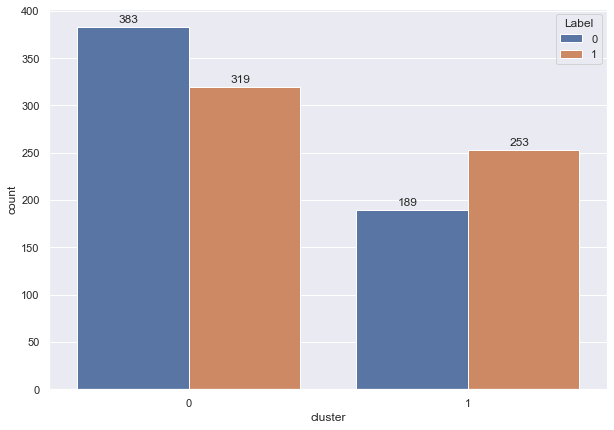

In [52]:
# plot distribution of target and non-target companies in each cluster
cluster_map["Label"] = y.values
sns.set(rc = {'figure.figsize':(10,7)})
ax = sns.countplot(x = "cluster", hue = "Label", data = cluster_map)

# add numeric values on the bars
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.15, p.get_height() + 5))

Moving to clustered model outputs, the graph above shows number of target (Label 1) and non-target (Label 2) companies in each cluster. We can see that there are overall 702 observation in Cluster 0 and 442 observations in Cluster 1. The class distribution is slightly unbalanced towards target and non-target companies for cluster 1 and cluster 0 companies respectively. 

The table below summarizes cluster centroids for each cluster per variable. It is evident from the results that companies in Cluster 0 have higher liquidity and lower leverage. On the contrary, Cluster 1 companies are in a worse financial condition in terms of long-term leverage and short-term financial power. 

In [53]:
# get cluster centroids
cl_centroid = km.cluster_centers_

# store variable centroids in a dataframe
centroids = pd.DataFrame()
centroids["Variable"] = dat_cl.columns
centroids["Mean_cluster 0"] = cl_centroid[0]
centroids["Mean_cluster 1"] = cl_centroid[1]
centroids

,Variable,Mean_cluster 0,Mean_cluster 1
0,Current Ratio,2.805736,1.554494
1,Debt to EV,10.621829,47.207315
2,Cash to Capital,0.232080,0.065443
3,Net debt per share,0.236114,24.964022


Further we run logistic regression models on each cluster datapoints and discuss the results

In [54]:
lr_0 = LogisticRegression(solver = 'liblinear',random_state=0, penalty = 'l2')
lr_0.fit(X.iloc[cl_0_idx], y.iloc[cl_0_idx])

log_reg = sm.Logit(y.iloc[cl_0_idx], X.iloc[cl_0_idx]).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.670424
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                  702
Model:                          Logit   Df Residuals:                      688
Method:                           MLE   Df Model:                           13
Date:                Tue, 14 Sep 2021   Pseudo R-squ.:                 0.02694
Time:                        22:02:05   Log-Likelihood:                -470.64
converged:                       True   LL-Null:                       -483.67
Covariance Type:            nonrobust   LLR p-value:                   0.01668
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Abnormal return 60 day       0.0140      0.005      2.648      0.008       0.004

Logistic regression outputs from Cluster 0, which includes companies in better financial health, find similar results to Model based on the entire dataset. Particularly, Abnormal returns are significant in 1%, Profit to capital, Debt to EV ratios in 5%, and Price to Sales at a 10% significance level. In addition, Net debt per share is also significant at a 5% level. The directions of the impact of significant variables are mainly similar to the first model; however, the coefficient values are higher for the Cluster 1 model for all variables. The exception is leverage ratios, where the direction of coefficients is the opposite, suggesting that companies with lower Debt to EV and higher Net debt per share contribute to the acquisition.

In [55]:
lr_1 = LogisticRegression(solver = 'liblinear',random_state=0, penalty = 'l2')
lr_1.fit(X.iloc[cl_1_idx], y.iloc[cl_1_idx])

log_reg = sm.Logit(y.iloc[cl_1_idx], X.iloc[cl_1_idx]).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.648109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                  442
Model:                          Logit   Df Residuals:                      428
Method:                           MLE   Df Model:                           13
Date:                Tue, 14 Sep 2021   Pseudo R-squ.:                 0.05057
Time:                        22:02:10   Log-Likelihood:                -286.46
converged:                       True   LL-Null:                       -301.72
Covariance Type:            nonrobust   LLR p-value:                  0.003969
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Abnormal return 60 day       0.0078      0.006      1.292      0.196      -0.004

Furthermore, Model based on Cluster 1 data, which provides logistic regression outputs based on 442 low liquid and high-levered companies, suggests somewhat different results. Return on Sales proxying inefficient management is significant at 5% level and is in line with previous studies. The rest of the variables are insignificant except Net debt per share and Current ratios. It is worth mentioning that the coefficient for Net debt per share is negative, as was in Model based on Cluster 0 data. Moreover, the current ratio is significant at a 5% level, positively contributing to our earlier argument that observed target companies have higher liquidity.

#### 4.2.3 Comparison of unclustered and clustered results: The effect of clustering

In [56]:
print('\033[1m' + "Accuracy metrics for the model based on the entire dataset" + '\033[0m')
print('Classification accuracy: {:.3f}'.format(lr.score(X, y)))
print('ROC_AUC score: {:.3f}'.format(roc_auc_score(y, lr.predict_proba(X)[:, 1])))

print('\033[1m' + "\nAccuracy metrics for the model based on the Cluster 0 data" + '\033[0m')
print('Classification accuracy: {:.3f}'.format(lr_0.score(X.iloc[cl_0_idx], y.iloc[cl_0_idx])))
print('ROC_AUC score: {:.3f}'.format(roc_auc_score(y.iloc[cl_0_idx], lr_0.predict_proba(X.iloc[cl_0_idx])[:, 1])))

print('\033[1m' + "\nAccuracy metrics for the model based on the Cluster 1 data" + '\033[0m')
print('Classification accuracy on test set: {:.3f}'.format(lr_1.score(X.iloc[cl_1_idx], y.iloc[cl_1_idx])))
print('ROC_AUC score: {:.3f}'.format(roc_auc_score(y.iloc[cl_1_idx], lr_1.predict_proba(X.iloc[cl_1_idx])[:, 1])))

Accuracy metrics for the model based on the entire dataset
Classification accuracy: 0.575
ROC_AUC score: 0.602

Accuracy metrics for the model based on the Cluster 0 data
Classification accuracy: 0.595
ROC_AUC score: 0.618

Accuracy metrics for the model based on the Cluster 1 data
Classification accuracy on test set: 0.606
ROC_AUC score: 0.644


The comparison of the three models shows that Clustered models produce relatively better results according to the Accuracy, AUC measure, and Pseudo R squire. We believe that the AUC measure is a better estimate, considering that Clustered models are imbalanced, and equal to 0.6, 0.618, and 0.644 for Model 1, 2, and 3, respectively. Additionally, models on clustered data have better explanatory power as clustered models produced a more comprehensive view of significant variables. However, it is also worth noting that the difference in model accuracy is not radical and can be associated with the sample size, which is the smallest for Model 3. The difference becomes even smaller after the cross-validation. Results from stratified cross-validation with ten splits for accuracy and AUC scores are summarized in the table below.

In [542]:
cv = StratifiedKFold(n_splits=10)

# implement 10-k cross validation for each model
scores_acc = cross_val_score(lr, X, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
scores_roc = cross_val_score(lr, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('\033[1m' + "Accuracy metrics for the model based on the entire dataset after 10-fold cross-validation" + '\033[0m')
print('Accuracy: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('ROC_AUC score: %.3f (%.3f)' % (mean(scores_roc), std(scores_roc)))

scores_cl_0_acc = cross_val_score(lr_0,X.iloc[cl_0_idx], y.iloc[cl_0_idx], scoring = 'accuracy', cv = cv, n_jobs = -1)
scores_cl_0_roc = cross_val_score(lr_0,X.iloc[cl_0_idx], y.iloc[cl_0_idx], scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('\033[1m' + "\nAccuracy metrics for the model based on the Cluster 0 data after 10-fold cross-validation" + '\033[0m')
print('Accuracy: %.3f (%.3f)' % (mean(scores_cl_0_acc), std(scores_cl_0_acc)))
print('ROC_AUC score: %.3f (%.3f)' % (mean(scores_cl_0_roc), std(scores_cl_0_roc)))

scores_cl_1_acc = cross_val_score(lr_1,X.iloc[cl_1_idx], y.iloc[cl_1_idx], scoring = 'accuracy', cv = cv, n_jobs = -1)
scores_cl_1_roc = cross_val_score(lr_1,X.iloc[cl_1_idx], y.iloc[cl_1_idx], scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('\033[1m' + "\nAccuracy metrics for the model based on the Cluster 1 data after 10-fold cross-validation" + '\033[0m')
print('Accuracy: %.3f (%.3f)' % (mean(scores_cl_1_acc), std(scores_cl_1_acc)))
print('ROC_AUC score: %.3f (%.3f)' % (mean(scores_cl_1_roc), std(scores_cl_1_roc)))

Accuracy metrics for the model based on the entire dataset after 10-fold cross-validation
Accuracy: 0.565 (0.033)
ROC_AUC score: 0.578 (0.040)

Accuracy metrics for the model based on the Cluster 0 data after 10-fold cross-validation
Accuracy: 0.570 (0.051)
ROC_AUC score: 0.572 (0.048)

Accuracy metrics for the model based on the Cluster 1 data after 10-fold cross-validation
Accuracy: 0.577 (0.070)
ROC_AUC score: 0.593 (0.073)


It should be noted that the current comparison is only preliminary, and actual accuracies will depend on how well the models will generalize on the hold-out sample, which is discussed later in this chapter. Nevertheless, higher accuracy and AUC measures of clustered models after cross-validation indicate that clustering will improve accuracy. To ensure the robustness of our claim, the hypothesis is also tested on a hold-out sample. 

## Section 5: Out of sample predictive power of the model

As mentioned earlier, the predictive power of the model is estimated on the hold-out sample consisting of target group observations after 2020-01-01 and all non-target peer companies. The hold sample includes **84 target** and **1704** non-target companies The reason we test our model on highly unbalanced dataset is to to have a similar to natural world distribution of target and non-target companies.

### 5.1 Identification of optimal cut-off probability

To estimate the predictive power of the models, an optimal cut-off rather than an arbitrary one (0.5) needs to be identified. Considering that we  aim to compare two models (general and clustered) a universal approach is suggested. Considering unbalanced datasets of clustered models and the one from the hold-out sample, the optimal cut-off for the models is derived G-measure approach which is the geometric mean of precision and recall. The formula is given as follows:

<font size="3">  $$ \begin{array}{ll}
{G}_{measure} = \sqrt{Recall * Specificity} = \sqrt{TPR *  \frac {TN} {FP+TN}}
\end{array}$$
</font>

where

<font size="3">  $$ \begin{array}{ll}
\sqrt{TPR *  \frac {TN} {FP+TN}} = {(1 - \frac {FP} {FP + TN})}
\end{array}$$
</font>

and finally:
<font size="3">  $$ \begin{array}{ll}
{G}_{measure}  = \sqrt{TPR * (1-FPR)}
\end{array}$$
</font>

The cut-off is further used to classify companies and include in the portfolio. For the companies where target probability is bigger than the optimal cut-off model classifies as target and includes in the portfolio.

The following function allows to identify the optimal cut-off and highlights it in a plot.

In [57]:
def find_optimal_cutoff(model, X, y_true):
    '''
    Dependencies
    ------------
    Python library 'Plotnine' version 0.8.0    
    
    Parameters
    -----------
    Identify optimal threshold for the model based on Youden’s J index and plot ROC curve
        Input:
            model: name of the model for which optimal threshold is being calculates
            X (DataFrame): DataFrame of independent variables
            y_true (Series): Series of True Labels
        Output:
            threshold_opt (Series): Series of True Labels
            ROC curve
    '''    
    # get target probabilities
    lr_probs = model.predict_proba(X)
    lr_probs = lr_probs[:, 1]
    
    # create dataframe of TPR and FPR per threshold
    fpr, tpr, thresholds = roc_curve(y_true, lr_probs)
    df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
    
    # calculate optimal threshold based on Gmean
    gmean = np.sqrt(tpr  * (1 - fpr))
    index = np.argmax(gmean)
    threshold_opt = round(thresholds[index], ndigits = 4)
    gmean_opt = round(gmean[index], ndigits = 4)
    fpr_opt = round(fpr[index], ndigits = 4)
    tpr_opt = round(tpr[index], ndigits = 4)
    
    print('Best Threshold: {} with G-Mean: {}'.format(threshold_opt, gmean_opt))
    print('FPR: {}, TPR: {}'.format(fpr_opt, tpr_opt))
    
    # plot the ROC curve and the optimal point:
    # source of the visualization: https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293
    pn.options.figure_size = (6,4)
    return threshold_opt, (
        ggplot(data = df_fpr_tpr)+
        geom_point(aes(x = 'FPR',
                       y = 'TPR'),
                   size = 0.4)+
        geom_point(aes(x = fpr_opt,
                       y = tpr_opt),
                   color = '#981220',
                   size = 4)+
        geom_line(aes(x = 'FPR',
                      y = 'TPR'))+
        geom_text(aes(x = fpr_opt,
                      y = tpr_opt),
                  label = 'Optimal threshold: {}'.format(threshold_opt),
                  nudge_x = 0.14,
                  nudge_y = -0.10,
                  size = 10,
                  fontstyle = 'italic')+
        labs(title = 'ROC Curve')+
        xlab('False Positive Rate (FPR)')+
        ylab('True Positive Rate (TPR)')+
        theme_minimal()
    )

First we identify the optimal cut-off for the model based on the entire dataset using the function above.

Best Threshold: 0.4961 with G-Mean: 0.5865
FPR: 0.4056, TPR: 0.5787


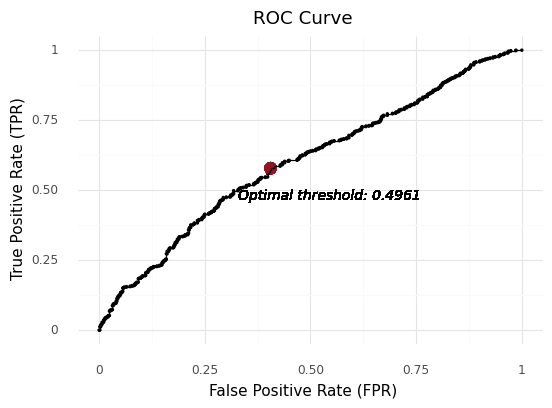

<ggplot: (144734231284)>

In [58]:
# get threshold for Model 1 and plot the ROC curve
threshold_opt, plot = find_optimal_cutoff(lr, X, y)
plot

Then we identify the optimal cut-off for the model based on the cluster 0 data.

Best Threshold: 0.4606 with G-Mean: 0.5826
FPR: 0.3916, TPR: 0.558


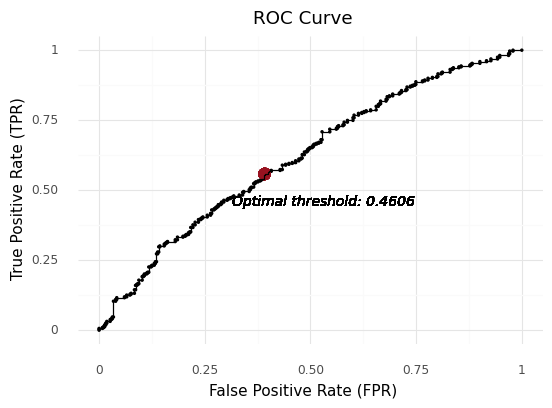

<ggplot: (144736750077)>

In [59]:
threshold_opt_cl_0, plot_cl_0 = find_optimal_cutoff(lr_0, X.iloc[cl_0_idx], y.iloc[cl_0_idx])
plot_cl_0

Finally, we identify the optimal cut-off for the model based on the cluster 1 data.

Best Threshold: 0.5902 with G-Mean: 0.6128
FPR: 0.291, TPR: 0.5296


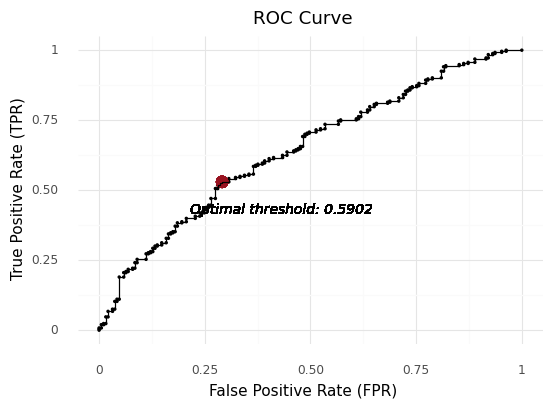

<ggplot: (144736728622)>

In [60]:
threshold_opt_cl_1, plot_cl_1 = find_optimal_cutoff(lr_1, X.iloc[cl_1_idx], y.iloc[cl_1_idx])
plot_cl_1

By employing this methodology, cut-off points of 0.4961, 0.460 and 0.5901 are determined for unclustered and cluster 0 and cluster 1 models respectively. The cut-offs mentioned above are employed to evaluate the predictive ability of the models, including Accuracy to determine how well the models identify actual targets and non-targets, Precision, Recall (TPR), and FPR to get further deeper insight on each aspect of the prediction as well as F1 score to evaluate the overall quality of different models. 

First we divide the holdout sample into dependent and independent variables

### 5.2 Classification results on the holdout sample

In [61]:
# drop to be removeded variables from hold-out sample
data_hold.drop(columns = drop, inplace = True)

In [62]:
# Separate independent and dependent variables
X_test = data_hold.drop(['AD-30', 'Announcement Date', 'Label',"Company RIC",'Market Cap','Total debt to Equity'], axis = 1)
y_test =  data_hold['Label']
X_test.head()

,Abnormal return 60 day,Gross Profit Margin,Profit to Capital,Return on Sales,EV to EBIDTA,"Sales growth, 3y",Free cash Flow/Sales,Current Ratio,Price to Sales,Market to Book,Debt to EV,Cash to Capital,Net debt per share,Growth-Resource Mismatch
0,-9.775437,59.18308,0.077847,4.544522,65.102980,0.521386,0.096377,1.38192,4.807378,11.428748,0.996802,1.002554,-6.270184,1
1,-7.701835,33.81626,0.056500,7.288653,40.759031,-2.363193,0.112886,2.69199,4.424246,4.644855,0.180739,0.098591,-0.842171,1
2,-11.843083,18.96168,-0.139595,2.823379,11.659163,3.438428,0.053293,1.86214,0.813417,2.430913,32.008828,0.193466,9.432784,1
3,-11.146474,32.09241,0.058989,7.491430,7.752199,2.581302,0.071953,1.89468,0.931876,1.780169,3.052414,0.107747,-1.440183,0
4,-9.647523,8.89214,-5.337401,-20.078817,113.200436,14.994174,-0.007138,0.52276,7.253047,45.870267,1.849967,0.044645,0.080742,0


#### 5.2.1 Results from the model on the entire dataset


First we calculate and report logistic regression outputs of the model based on the entire dataset

In [63]:
# get target probabilities
prob = lr.predict_proba(X_test)

# create dataframe and store model results
pred_res_lr = data_hold[['Announcement Date','Company RIC','Label']]
pred_res_lr.insert(loc = len(pred_res_lr.columns), column = "Probability_target", value = prob[:,1])
pred_res_lr.insert(loc = len(pred_res_lr.columns), column = "Class", value = np.where(pred_res_lr['Probability_target'] > threshold_opt, 1, 0))

# assign TP/FP/TN/FN labels based on the specified cut-off probability
pred_res_lr.insert(loc = len(pred_res_lr.columns), column = "Outcome", value = 
                np.where((pred_res_lr['Class'] == 1) & (pred_res_lr['Label'] == 1), "TP", 
                np.where((pred_res_lr['Class'] == 1) & (pred_res_lr['Label'] == 0),"FP",
                np.where((pred_res_lr['Class'] == 0) & (pred_res_lr['Label'] == 1),"FN", "TN"))))

pred_res_lr.head()

,Announcement Date,Company RIC,Label,Probability_target,Class,Outcome
0,2021-06-28,QADA.O,1,0.403778,0,FN
1,2021-06-21,RAVN.O,1,0.367537,0,FN
2,2021-06-21,LDL,1,0.487374,0,FN
3,2021-06-18,SYKE.OQ^H21,1,0.416753,0,FN
4,2021-06-08,MCF,1,0.971662,1,TP


In [64]:
print('\033[1m' + "Observations" + '\033[0m')
print(f'Total Number of companies: {pred_res_lr.shape[0]}')
print('Number of target companies: ' +  str(pred_res_lr.loc[pred_res_lr['Label'] == 1].shape[0]))
print('Number of non-companies: ' +  str(pred_res_lr.loc[pred_res_lr['Label'] == 0].shape[0]))

# calculate confusion matrix data based on specified cut-off probability
TP_lr = pred_res_lr.loc[pred_res_lr['Outcome'] == "TP"].shape[0]
TN_lr = pred_res_lr.loc[pred_res_lr['Outcome'] == "TN"].shape[0]
FP_lr = pred_res_lr.loc[pred_res_lr['Outcome'] == "FP"].shape[0]
FN_lr = pred_res_lr.loc[pred_res_lr['Outcome'] == "FN"].shape[0]

print('\033[1m' + "\nAbsolute Measures" + '\033[0m')
print(f'TP: {TP_lr}')
print(f'TN: {TN_lr}')
print(f'FP(Type II error): {FP_lr}')
print(f'FN(Type I error): {FN_lr}')

print('\033[1m' + "\nRelative Measures" + '\033[0m')
print('ROC score:' + str (round(roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]),2)))
print(f'Accuracy: {round((TP_lr + TN_lr) / (TP_lr + TN_lr + FP_lr + FN_lr),2)}')
print(f'Precision: {round(TP_lr / (TP_lr + FP_lr),2)}')
print(f'Recall(TPR): {round(TP_lr / (TP_lr + FN_lr),2)}')
print(f'FPR: {round(FP_lr / (FP_lr + TN_lr),2)}')
print(f'F1 score: {round(2*(TP_lr / (TP_lr + FP_lr)) * (TP_lr / (TP_lr + FN_lr) / ((TP_lr / (TP_lr + FP_lr)) + (TP_lr / (TP_lr + FN_lr)))),2)}')

Observations
Total Number of companies: 1788
Number of target companies: 84
Number of non-companies: 1704

Absolute Measures
TP: 48
TN: 982
FP(Type II error): 722
FN(Type I error): 36

Relative Measures
ROC score:0.6
Accuracy: 0.58
Precision: 0.06
Recall(TPR): 0.57
FPR: 0.42
F1 score: 0.11


The model based on the entire dataset correctly identifies 58% of targets and non-targets, which equals 48 out of 84 for targets and 982 out of 1704 for non-targets in absolute measures. Additionally, the Model has a large Type II error, resulting in a very low precision of 0.06. The recall is relatively higher due to lower Type I error and higher True positives. The resulting F1 score is 0.11. 

Then we divide the entire dataset into two clusters using the kmeans model we have trained earlier.

#### 5.2.2 Results from the models on seperate clusters

In [65]:
# set the hold out sample for clustering
datahold_cl =  data_hold.drop(cl_drop, axis = 1)
datahold_cl = datahold_cl.drop(['AD-30','Announcement Date','Company RIC','Market Cap'], axis=1)

# cluster the hold out sample
cl_preds = km.predict(datahold_cl)

cl_0_idx_t = []
cl_1_idx_t = []

for i in range(len(cl_preds)):
    if cl_preds[i] == 0:
        cl_0_idx_t.append(i)
    if cl_preds[i] == 1:
        cl_1_idx_t.append(i)
        
print("Number of elements in Cluster 0 is" , len(cl_0_idx_t))
print("Number of elements in Cluster 1 is" , len(cl_1_idx_t))

Number of elements in Cluster 0 is 1143
Number of elements in Cluster 1 is 645


We calculate and report logistic regression outputs of the models based on Cluster 0 and Cluster 1 separately. Below are the results from the Cluster 0 model.

In [66]:
y_pred_lr_0 = lr_0.predict(X_test.iloc[cl_0_idx_t])
prob_0 = lr_0.predict_proba(X_test.iloc[cl_0_idx_t])

df_c = data_hold[['Announcement Date','Company RIC','Label']]

pred_res_lr_0 = df_c.iloc[cl_0_idx_t]
pred_res_lr_0.insert(loc = len(pred_res_lr_0.columns), column = 'Cluster', value = [0] * len(cl_0_idx_t))
pred_res_lr_0.insert(loc = len(pred_res_lr_0.columns), column = 'Probability_target', value = prob_0[:,1])
pred_res_lr_0.insert(loc = len(pred_res_lr_0.columns), column = 'Class', value = np.where(pred_res_lr_0['Probability_target'] > threshold_opt_cl_0, 1, 0))

pred_res_lr_0.insert(loc = len(pred_res_lr_0.columns), column = "Outcome", value = 
                np.where((pred_res_lr_0['Class'] == 1) & (pred_res_lr_0['Label'] == 1), "TP", 
                np.where((pred_res_lr_0['Class'] == 1) & (pred_res_lr_0['Label'] == 0),"FP",
                np.where((pred_res_lr_0['Class'] == 0) & (pred_res_lr_0['Label'] == 1),"FN", "TN"))))


pred_res_lr_0.head()

,Announcement Date,Company RIC,Label,Cluster,Probability_target,Class,Outcome
0,2021-06-28,QADA.O,1,0,0.489038,1,TP
1,2021-06-21,RAVN.O,1,0,0.363049,0,FN
3,2021-06-18,SYKE.OQ^H21,1,0,0.389464,0,FN
4,2021-06-08,MCF,1,0,0.975591,1,TP
7,2021-06-06,ALU.AX,1,0,0.418407,0,FN


In [67]:
print('\033[1m' + "Observations" + '\033[0m')
print(f'Total Number of companies: {pred_res_lr_0.shape[0]}')
print('Total Number of companies: ' +  str(pred_res_lr_0.loc[pred_res_lr_0['Label'] == 1].shape[0]))
print('Total Number of companies: ' +  str(pred_res_lr_0.loc[pred_res_lr_0['Label'] == 0].shape[0]))

TP_lr_0 = pred_res_lr_0.loc[pred_res_lr_0['Outcome'] == "TP"].shape[0]
TN_lr_0 = pred_res_lr_0.loc[pred_res_lr_0['Outcome'] == "TN"].shape[0]
FP_lr_0 = pred_res_lr_0.loc[pred_res_lr_0['Outcome'] == "FP"].shape[0]
FN_lr_0 = pred_res_lr_0.loc[pred_res_lr_0['Outcome'] == "FN"].shape[0]

print('\033[1m' + "\nAbsolute Measures" + '\033[0m')
print(f'TP: {TP_lr_0}')
print(f'TN: {TN_lr_0}')
print(f'FP(Type II error): {FP_lr_0}')
print(f'FN(Type I error): {FN_lr_0}')

print('\033[1m' + "\nRelative Measures" + '\033[0m')
print('ROC score:' + str (round(roc_auc_score(y_test.iloc[cl_0_idx_t], lr_0.predict_proba(X_test.iloc[cl_0_idx_t])[:, 1]),2)))
print(f'Accuracy: {round((TP_lr_0 + TN_lr_0) / (TP_lr_0 + TN_lr_0 + FP_lr_0 + FN_lr_0),2)}')
print(f'Precision: {round(TP_lr_0 / (TP_lr_0 + FP_lr_0),2)}')
print(f'Recall(TPR): {round(TP_lr_0 / (TP_lr_0 + FN_lr_0),2)}')
print(f'FPR: {round(FP_lr_0 / (FP_lr_0 + TN_lr_0),2)}')
print(f'F1 score: {round(2*(TP_lr_0 / (TP_lr_0 + FP_lr_0)) * (TP_lr_0 / (TP_lr_0 + FN_lr_0) / ((TP_lr_0 / (TP_lr_0 + FP_lr_0)) + (TP_lr_0 / (TP_lr_0 + FN_lr_0)))),2)}')

Observations
Total Number of companies: 1143
Total Number of companies: 45
Total Number of companies: 1098

Absolute Measures
TP: 27
TN: 697
FP(Type II error): 401
FN(Type I error): 18

Relative Measures
ROC score:0.65
Accuracy: 0.63
Precision: 0.06
Recall(TPR): 0.6
FPR: 0.37
F1 score: 0.11


Cluster 0 model, which encompasses companies with better financial health, has a higher predictive power of identifying non-targets than targets, 64% (697 out 1143) and 59% (27 out of 45). The large number of identified true negatives results in the lowest FPR and the highest accuracy among the models. However, a large Type I error results in one of the lowest precision scores for the model, which is 0.6 and equal to the precision of the general model. The resulting F1 score is also similar to the one from the model based on the entire dataset. 

Further we report the results from the Cluster 1 model

In [68]:
y_pred_lr_1 = lr_1.predict(X_test.iloc[cl_1_idx_t])
prob_1 = lr_1.predict_proba(X_test.iloc[cl_1_idx_t])

pred_res_lr_1 = df_c.iloc[cl_1_idx_t]
pred_res_lr_1.insert(loc = len(pred_res_lr_1.columns), column = 'Cluster', value = [0] * len(cl_1_idx_t))
pred_res_lr_1.insert(loc = len(pred_res_lr_1.columns), column = 'Probability_target', value = prob_1[:,1])
pred_res_lr_1.insert(loc = len(pred_res_lr_1.columns), column = 'Class', value = np.where(pred_res_lr_1['Probability_target'] > threshold_opt_cl_1, 1, 0))

pred_res_lr_1.insert(loc = len(pred_res_lr_1.columns), column = "Outcome", value = 
                np.where((pred_res_lr_1['Class'] == 1) & (pred_res_lr_1['Label'] == 1), "TP", 
                np.where((pred_res_lr_1['Class'] == 1) & (pred_res_lr_1['Label'] == 0),"FP",
                np.where((pred_res_lr_1['Class'] == 0) & (pred_res_lr_1['Label'] == 1),"FN", "TN"))))

pred_res_lr_1.head()

,Announcement Date,Company RIC,Label,Cluster,Probability_target,Class,Outcome
2,2021-06-21,LDL,1,0,0.535761,0,FN
5,2021-06-07,QTS.N^I21,1,0,0.529560,0,FN
6,2021-06-07,USCR.OQ^H21,1,0,0.461561,0,FN
9,2021-05-28,WBT,1,0,0.612057,1,TP
12,2021-05-04,UFS,1,0,0.558860,0,FN


In [69]:
print('\033[1m' + "Observations" + '\033[0m')
print(f'Total Number of companies: {pred_res_lr_1.shape[0]}')
print('Total Number of companies: ' +  str(pred_res_lr_1.loc[pred_res_lr_1['Label'] == 1].shape[0]))
print('Total Number of companies: ' +  str(pred_res_lr_1.loc[pred_res_lr_1['Label'] == 0].shape[0]))

TP_lr_1 = pred_res_lr_1.loc[pred_res_lr_1['Outcome'] == "TP"].shape[0]
TN_lr_1 = pred_res_lr_1.loc[pred_res_lr_1['Outcome'] == "TN"].shape[0]
FP_lr_1 = pred_res_lr_1.loc[pred_res_lr_1['Outcome'] == "FP"].shape[0]
FN_lr_1 = pred_res_lr_1.loc[pred_res_lr_1['Outcome'] == "FN"].shape[0]

print('\033[1m' + "\nAbsolute Measures" + '\033[0m')
print(f'TP: {TP_lr_1}')
print(f'TN: {TN_lr_1}')
print(f'FP(Type II error): {FP_lr_1}')
print(f'FN(Type I error): {FN_lr_1}')

print('\033[1m' + "\nRelative Measures" + '\033[0m')
print('ROC score:' + str (round(roc_auc_score(y_test.iloc[cl_1_idx_t], lr_0.predict_proba(X_test.iloc[cl_1_idx_t])[:, 1]),2)))
print(f'Accuracy: {round((TP_lr_1 + TN_lr_1) / (TP_lr_1 + TN_lr_1 + FP_lr_1 + FN_lr_1),2)}')
print(f'Precision: {round(TP_lr_1 / (TP_lr_1 + FP_lr_1),2)}')
print(f'Recall(TPR): {round(TP_lr_1 / (TP_lr_1 + FN_lr_1),2)}')
print(f'FPR: {round(FP_lr_1 / (FP_lr_1 + TN_lr_1),2)}')
print(f'F1 score: {round(2*(TP_lr_1 / (TP_lr_1 + FP_lr_1)) * (TP_lr_1 / (TP_lr_1 + FN_lr_1) / ((TP_lr_1 / (TP_lr_1 + FP_lr_1)) + (TP_lr_1 / (TP_lr_1 + FN_lr_1)))),2)}')

Observations
Total Number of companies: 645
Total Number of companies: 39
Total Number of companies: 606

Absolute Measures
TP: 28
TN: 319
FP(Type II error): 287
FN(Type I error): 11

Relative Measures
ROC score:0.45
Accuracy: 0.54
Precision: 0.09
Recall(TPR): 0.72
FPR: 0.47
F1 score: 0.16


Moving to the Cluster 1 model, which involves low-liquid and high-levered companies, has the highest accurate identification of target companies. The model correctly identifies 28 targets out of 39, 72% in relative measures. In contrast, the model has the poorest ability to predict actual non-targets, particularly 52% or 319 out of 606 non-targets. Considering the highly toward non-targets unbalanced (95:5) hold-out sample, the  predictions mentioned above result in the lowest accuracy of 0.54 compared to the other models. However, due to the relatively accurate prediction of targets and smaller Type I error, the model produces the highest recall and precision scores, 0.72 and 0.09, respectively. The F1 score is also the highest and is equal to 0.16.

As can be noticed Clustered models characterize with diverged results. That can be attributed to an assumption that models overall predict well for the companies which are in bad financial health. This assumption is supported on both clustered models, as Cluster 0, which involved companies in good financial health, better identifies non-targets (potentially financially distressed), and Cluster 1, which involved companies with lower liquidity and higher leverage, better identifies the targets (again potentially financially distressed). 

Finally we calculate and report also combined results of clustering to be able to better measure the impact of clustering on logistic regression prediction accuracy.

In [70]:
pred_res_combined = pd.concat([pred_res_lr_0,pred_res_lr_1], ignore_index=True)
pred_res_combined

,Announcement Date,Company RIC,Label,Cluster,Probability_target,Class,Outcome
0,2021-06-28,QADA.O,1,0,0.489038,1,TP
1,2021-06-21,RAVN.O,1,0,0.363049,0,FN
2,2021-06-18,SYKE.OQ^H21,1,0,0.389464,0,FN
3,2021-06-08,MCF,1,0,0.975591,1,TP
4,2021-06-06,ALU.AX,1,0,0.418407,0,FN
...,...,...,...,...,...,...,...
1783,2020-01-06,AEG.TO,0,0,0.718261,1,FP
1784,2020-01-06,LUB.N,0,0,0.718315,1,FP
1785,2020-01-06,BH.N,0,0,0.463615,0,TN
1786,2020-01-06,TACO.OQ,0,0,0.696414,1,FP


In [71]:
print('\033[1m' + "Observations" + '\033[0m')
print(f'Total Number of companies: {pred_res_combined.shape[0]}')
print('Total Number of companies: ' +  str(pred_res_combined.loc[pred_res_combined['Label'] == 1].shape[0]))
print('Total Number of companies: ' +  str(pred_res_combined.loc[pred_res_combined['Label'] == 0].shape[0]))

TP_lr_comb = pred_res_combined.loc[pred_res_combined['Outcome'] == "TP"].shape[0]
TN_lr_comb = pred_res_combined.loc[pred_res_combined['Outcome'] == "TN"].shape[0]
FP_lr_comb = pred_res_combined.loc[pred_res_combined['Outcome'] == "FP"].shape[0]
FN_lr_comb = pred_res_combined.loc[pred_res_combined['Outcome'] == "FN"].shape[0]

print('\033[1m' + "\nAbsolute Measures" + '\033[0m')
print(f'TP: {TP_lr_comb}')
print(f'TN: {TN_lr_comb}')
print(f'FP(Type II error): {FP_lr_comb}')
print(f'FN(Type I error): {FN_lr_comb}')

print('\033[1m' + "\nRelative Measures" + '\033[0m')
print(f'Accuracy: {round((TP_lr_comb + TN_lr_comb) / (TP_lr_comb + TN_lr_comb + FP_lr_comb + FN_lr_comb),2)}')
print(f'Precision: {round(TP_lr_comb / (TP_lr_comb + FP_lr_comb),2)}')
print(f'Recall(TPR): {round(TP_lr_comb / (TP_lr_comb + FN_lr_comb),2)}')
print(f'FPR: {round(FP_lr_comb / (FP_lr_comb + TN_lr_comb),2)}')
print(f'F1 score: {round(2*(TP_lr_comb / (TP_lr_comb + FP_lr_comb)) * (TP_lr_comb / (TP_lr_comb + FN_lr_comb) / ((TP_lr_comb / (TP_lr_comb + FP_lr_comb)) + (TP_lr_comb / (TP_lr_comb + FN_lr_comb)))),2)}')


Observations
Total Number of companies: 1788
Total Number of companies: 84
Total Number of companies: 1704

Absolute Measures
TP: 55
TN: 1016
FP(Type II error): 688
FN(Type I error): 29

Relative Measures
Accuracy: 0.6
Precision: 0.07
Recall(TPR): 0.65
FPR: 0.4
F1 score: 0.13


As for the combined results derived based on a weighted cut-off, all metrics expectedly lie between Cluster 0 and Cluster 1. According to the combined outputs, 65% of targets and 60% of targets are identified through clustering, which is better than the model without clustering. The latter correctly identified only 58% of the targets and non-targets. Both Type I and Type II errors are higher for the general model, which allows us to conclude that clustering helps to reduce the errors. Due to higher accuracy and low erroneous predictions, the clustering results in better predictive power, as in terms of overall accuracy, 0.6 against 0.58, as well as F1 score (0.13 against 0.11) as a combined metric of precision versus recall trade-off. 

Overall, the results from the current and previous sections allow us to confirm that clustering improves the prediction accuracy of logistic regression models for target prediction.  It is also worth mentioning that Clustered models can be used as combined as well as separately in the portfolio construction process. Particularly, one can buy only targets predicted by the Cluster 1 or Cluster 0 model instead of buying them all, considering the different predictive abilities of two models.


## Section 6: Portfolio returns

### 6.1 Announcement returns

Before estimating portfolio returns based on the predictions from 3 different models, announcement returns are calculated and illustrated with a plot. This provides an insight into the potential portfolio returns that can be generated by correctly identifying target companies.

First we create a dataframe containing the RICs of hold-out sample companies and key dates of estimation and observation periods of abnormal return calculation.

In [72]:
# create a dataframe for abnormal returns calculation with necessary dates
companies = data_hold[['Company RIC', 'Announcement Date', 'Label']]
companies.insert(loc = len(companies.columns), column = 'ad-250', value = companies['Announcement Date'] - datetime.timedelta(250))
companies.insert(loc = len(companies.columns), column = 'ad-60', value = companies['Announcement Date'] - datetime.timedelta(60))
companies.insert(loc = len(companies.columns), column = 'ad+3', value = companies['Announcement Date'] + datetime.timedelta(3))
companies.insert(loc = len(companies.columns), column = 'ad+20', value = companies['Announcement Date'] + datetime.timedelta(20))
companies.head()

,Company RIC,Announcement Date,Label,ad-250,ad-60,ad+3,ad+20
0,QADA.O,2021-06-28,1,2020-10-21,2021-04-29,2021-07-01,2021-07-18
1,RAVN.O,2021-06-21,1,2020-10-14,2021-04-22,2021-06-24,2021-07-11
2,LDL,2021-06-21,1,2020-10-14,2021-04-22,2021-06-24,2021-07-11
3,SYKE.OQ^H21,2021-06-18,1,2020-10-11,2021-04-19,2021-06-21,2021-07-08
4,MCF,2021-06-08,1,2020-10-01,2021-04-09,2021-06-11,2021-06-28


After the dataframe is created, abnormal returns for each target company in the holdout sample is estimated using the function described in the begining of this article.

In [73]:
# store target companies in a separate dataframe
targets = companies.loc[companies['Label'] == 1]

# create lists for ab_return function parameters
RIC_t = targets['Company RIC']
sdate_t = targets['ad-250'].dt.strftime('%Y-%m-%d').to_list()
edate_t = targets['ad-60'].dt.strftime('%Y-%m-%d').to_list()
ann_date_t = targets['ad+20'].dt.strftime('%Y-%m-%d').to_list()

# create an empty dataframe to store retrieved abnormal returns
abreturn_targets = pd.DataFrame({'#': np.arange(start = 1, stop = 80)})

# get abnormal returns for specified companies during the specified period using the function
for i in range(len(RIC_t)):
    CAR, abnormal_returns = ab_return(RIC_t[i], sdate_t[i], edate_t[i], ann_date_t[i], 80)
    abreturn_targets.insert(loc = len(abreturn_targets.columns), column = RIC_t[i] + "/" + sdate_t[i], value = abnormal_returns.iloc[:,2])
abreturn_targets.head()

,#,QADA.O/2020-10-21,RAVN.O/2020-10-14,LDL/2020-10-14,SYKE.OQ^H21/2020-10-11,MCF/2020-10-01,QTS.N^I21/2020-09-30,USCR.OQ^H21/2020-09-30,ALU.AX/2020-09-29,CLDR.K/2020-09-24,...,GLIBA.O^L20/2019-10-24,MINI.O^G20/2019-06-26,XPER.O/2019-06-18,IOTS.O^F20/2019-06-15,FSCT.O^H20/2019-06-01,POPE.O^E20/2019-05-10,PRMW.O^C20/2019-05-08,HXL/2019-05-07,DERM.O^B20/2019-05-05,HABT.O^C20/2019-05-01
0,1,-1.951212,1.789674,0.647811,-1.340482,-3.464857,-0.938509,-0.390116,0.233426,0.987546,...,0.730205,0.404776,-1.69255,4.279967,1.407284,-0.500029,0.667141,1.481534,0.494524,0.51578
1,2,0.169606,-1.020053,-1.074035,0.038024,0.63128,0.575662,-0.215277,0.411751,-2.603475,...,-0.759163,-0.486181,1.112555,3.068245,-0.639972,-0.269045,-3.550817,-0.16982,0.063426,1.777091
2,3,-0.922917,0.445024,2.533315,1.74993,1.591846,1.21047,-6.187087,0.531499,1.902075,...,-1.080253,0.301547,0.255182,3.554056,0.769056,-0.22176,-0.847796,-0.655486,-6.877575,0.135701
3,4,-0.321588,0.618946,5.371113,-0.73537,-5.662016,-0.567464,3.221014,2.527593,-0.665821,...,1.020085,-0.149288,-1.004653,5.529008,1.005436,1.596167,2.552246,-0.340613,0.20865,-0.946638
4,5,-3.229711,-1.168822,1.329981,-0.410937,-0.830568,2.084242,-2.789562,3.016393,-0.52657,...,-0.688504,-0.848708,-1.03037,0.261553,0.267546,1.372257,1.975911,0.715192,1.144629,-0.696808


After retrieving abnormal returns for all of the target companies, we calculate cumulative sum of the returns and plot through a lineplot.

<AxesSubplot:ylabel='Total return'>

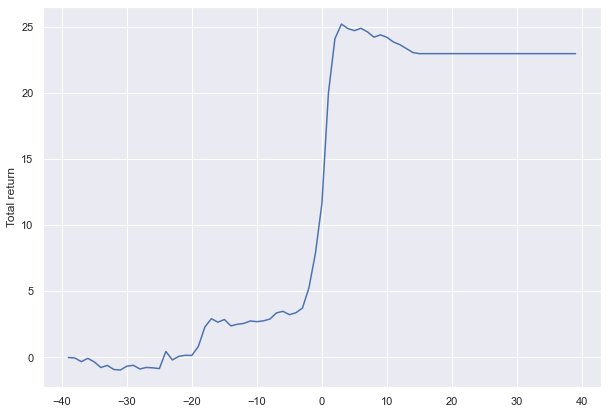

In [74]:
# remove the first row and calculate total return from all of the stocks per observation date
abreturn_targets.drop(columns = ['#'], inplace = True)
abreturn_targets.insert(loc = len(abreturn_targets.columns), column = 'Total return', value = abreturn_targets.sum(axis =1)/84)

# calculate cumulative sum of total returns and plot in a graph
abreturn_targets = abreturn_targets.cumsum(axis = 0)
sns.lineplot(data = abreturn_targets, y = "Total return", x = np.arange(-39, 40))

In line with previous empirical studies (Jensen & Ruback, 1983; Danbolt, 2004), we can observe positive abnormal announcement returns during the event windows, which exceeds 25% after the announcement day. The decline in Average CAR after the announcement is explained by the fact that the stock price of the to-be-acquired company remains stable (equal to per stock acquisition price) while the market, against which abnormal returns are calculated, moves. During our observation, S&P 500 index, used as a market proxy, increased, resulting in a decline in the target company’s stock abnormal returns.

It can also be observed that a considerable portion of abnormal returns is already generated before the announcement date, which Schwert (1996) denoted as run-up returns. Significant run-up returns also explain the statistical significance and strong positive coefficient of the Abnormal return variable in our models.

The results of this section imply that shareholders of target companies can generate positive abnormal returns, and a target prediction model identifying targets at a certain accuracy can generate portfolio abnormal returns.

### 6.2 Portfolio returns

After evaluating the predictive power of the models and showing the potential abnormal returns that the models can potentially generate, we now estimate the ability and level of abnormal returns that models actually capture. Two types of portfolio returns are calculated in this section. First, we estimate portfolio abnormal returns to measure the actual return size that the models could capture from the total announcement returns. Second, we test an investment strategy of buying and selling predicted target company stocks and compare generated returns with the market return to measure the market-adjusted excess return of our portfolios

#### 6.2.1 Portfolio Abnormal Returns

Here we estimate the level of abnormal returns that the portfolios constructed based on the the prediction models can capture. To do that, abnormal returns for each target company in the holdout sample is estimated using the function described in the beginning of this article.

In [89]:
RIC = companies['Company RIC']
sdate = companies['ad-250'].dt.strftime('%Y-%m-%d').to_list()
edate = companies['ad-60'].dt.strftime('%Y-%m-%d').to_list()
ann_date = companies['ad+3'].dt.strftime('%Y-%m-%d').to_list()

In [ ]:
# it takes relatively long to execute this code. The values can be read from excel for this particular example
return_list = []
for i in range(len(RIC)):
    CAR, abnormal_returns = ab_return(RIC[i], sdate[i], edate[i], ann_date[i], 60)
    return_list.append(CAR)

In [75]:
# return_list =  pd.read_excel (r'ab_ret.xlsx')
# return_list = return_list.iloc[:,1]

First we calculate and report portfolio abnormal returns from the portfolio created by the model based on the entire dataset.

In [76]:
# add returns to the prediction result dataframe
pred_res_lr.insert(loc = len(pred_res_lr.columns), column = "Abnormal Return", value = return_list)
pred_res_lr.head()

,Announcement Date,Company RIC,Label,Probability_target,Class,Outcome,Abnormal Return
0,2021-06-28,QADA.O,1,0.403778,0,FN,7.043903
1,2021-06-21,RAVN.O,1,0.367537,0,FN,37.238713
2,2021-06-21,LDL,1,0.487374,0,FN,67.654569
3,2021-06-18,SYKE.OQ^H21,1,0.416753,0,FN,19.197178
4,2021-06-08,MCF,1,0.971662,1,TP,-12.068867


In [77]:
print('\033[1m' + "Portfolio composition" + '\033[0m')
print('Predicted targtes: ' +  str(pred_res_lr.loc[pred_res_lr['Class'] == 1].shape[0]))
print('Among which Actual Targets: ' +  str(pred_res_lr.loc[(pred_res_lr['Label'] == 1) & (pred_res_lr['Class'] == 1)].shape[0]))
print('Among which Actual Non-Targets: ' +  str(pred_res_lr.loc[(pred_res_lr['Label'] == 0) & (pred_res_lr['Class'] == 1)].shape[0]))

print('\033[1m' + "\nAccuracy Metrics" + '\033[0m')
print(f'Recall(TPR): {round(TP_lr / (TP_lr + FN_lr),2)}')
print(f'FPR: {round(FP_lr / (FP_lr + TN_lr),2)}')
print(f'F1 score: {round(2*(TP_lr / (TP_lr + FP_lr)) * (TP_lr / (TP_lr + FN_lr) / ((TP_lr / (TP_lr + FP_lr)) + (TP_lr / (TP_lr + FN_lr)))),2)}')

print('\033[1m' + "\nPortfolio Abnormal Return" + '\033[0m')
print("From actual targets: " + str(round(pred_res_lr['Abnormal Return'].loc[(pred_res_lr['Class'] == 1) & (pred_res_lr['Label'] == 1)].mean(),2)))
print("From actual non-targets: " + str(round(pred_res_lr['Abnormal Return'].loc[(pred_res_lr['Class'] == 1) & (pred_res_lr['Label'] == 0)].mean(),2)))
print("Weighted Total: " + str(round(pred_res_lr['Abnormal Return'].loc[pred_res_lr['Class'] == 1].mean(),2)))

Portfolio composition
Predicted targtes: 770
Among which Actual Targets: 48
Among which Actual Non-Targets: 722

Accuracy Metrics
Recall(TPR): 0.57
FPR: 0.42
F1 score: 0.11

Portfolio Abnormal Return
From actual targets: 27.11
From actual non-targets: 6.3
Weighted Total: 7.6


The portfolio constructed based on the entire dataset comprises of 770 companies. Among them, only 48 are actual targets, which converts into 0.58 and 0.42 TPR and FPR, respectively. Despite large Type II errors, the model is able to generate 7.6 % of weighted total abnormal return. Additionally, we observe that actual targets generate considerably more returns, 27.11 %, which is diluted by the returns from non-target companies. Nevertheless, predicted as target non-targets still generate a positive 7.6 % abnormal return. 

Then we calculate and report portfolio abnormal returns from the portfolio created by the model trained on Cluster 0 companies.

In [78]:
idx_lr_0 = pred_res_lr_0.index.values.tolist()
return_list_lr_0 = [return_list[index] for index in idx_lr_0]

pred_res_lr_0.insert(loc = len(pred_res_lr_0.columns), column = "Abnormal Return", value = return_list_lr_0)
pred_res_lr_0.head()

,Announcement Date,Company RIC,Label,Cluster,Probability_target,Class,Outcome,Abnormal Return
0,2021-06-28,QADA.O,1,0,0.489038,1,TP,7.043903
1,2021-06-21,RAVN.O,1,0,0.363049,0,FN,37.238713
3,2021-06-18,SYKE.OQ^H21,1,0,0.389464,0,FN,19.197178
4,2021-06-08,MCF,1,0,0.975591,1,TP,-12.068867
7,2021-06-06,ALU.AX,1,0,0.418407,0,FN,37.302351


In [79]:
print('\033[1m' + "Portfolio composition" + '\033[0m')
print('Predicted targtes: ' +  str(pred_res_lr_0.loc[pred_res_lr_0['Class'] == 1].shape[0]))
print('Among which Actual Targets: ' +  str(pred_res_lr_0.loc[(pred_res_lr_0['Label'] == 1) & (pred_res_lr_0['Class'] == 1)].shape[0]))
print('Among which Actual Non-Targets: ' +  str(pred_res_lr_0.loc[(pred_res_lr_0['Label'] == 0) & (pred_res_lr_0['Class'] == 1)].shape[0]))

print('\033[1m' + "\nAccuracy Metrics" + '\033[0m')
print(f'Recall(TPR): {round(TP_lr_0 / (TP_lr_0 + FN_lr_0),2)}')
print(f'FPR: {round(FP_lr_0 / (FP_lr_0 + TN_lr_0),2)}')
print(f'F1 score: {round(2*(TP_lr_0 / (TP_lr_0 + FP_lr_0)) * (TP_lr_0 / (TP_lr_0 + FN_lr_0) / ((TP_lr_0 / (TP_lr_0 + FP_lr_0)) + (TP_lr_0 / (TP_lr_0 + FN_lr_0)))),2)}')

print('\033[1m' + "\nPortfolio Abnormal Return" + '\033[0m')
print("From actual targets: " + str(round(pred_res_lr_0['Abnormal Return'].loc[(pred_res_lr_0['Class'] == 1) & (pred_res_lr_0['Label'] == 1)].mean(),2)))
print("From actual non-targets: " + str(round(pred_res_lr_0['Abnormal Return'].loc[(pred_res_lr_0['Class'] == 1) & (pred_res_lr_0['Label'] == 0)].mean(),2)))
print("Weighted Total: " + str(round(pred_res_lr_0['Abnormal Return'].loc[pred_res_lr_0['Class'] == 1].mean(),2)))

Portfolio composition
Predicted targtes: 428
Among which Actual Targets: 27
Among which Actual Non-Targets: 401

Accuracy Metrics
Recall(TPR): 0.6
FPR: 0.37
F1 score: 0.11

Portfolio Abnormal Return
From actual targets: 29.91
From actual non-targets: 6.17
Weighted Total: 7.67


Finally, we calculate and report portfolio abnormal returns from the portfolio created by the model trained on the Cluster 1 companies.

In [80]:
idx_lr_1 = pred_res_lr_1.index.values.tolist()
return_list_lr_1 = [return_list[index] for index in idx_lr_1]

pred_res_lr_1.insert(loc = len(pred_res_lr_1.columns), column = "Abnormal Return", value = return_list_lr_1)
pred_res_lr_1.head()

,Announcement Date,Company RIC,Label,Cluster,Probability_target,Class,Outcome,Abnormal Return
2,2021-06-21,LDL,1,0,0.535761,0,FN,67.654569
5,2021-06-07,QTS.N^I21,1,0,0.529560,0,FN,23.582321
6,2021-06-07,USCR.OQ^H21,1,0,0.461561,0,FN,-6.415038
9,2021-05-28,WBT,1,0,0.612057,1,TP,21.790218
12,2021-05-04,UFS,1,0,0.558860,0,FN,10.252468


In [81]:
print('\033[1m' + "Portfolio composition" + '\033[0m')
print('Predicted targtes: ' +  str(pred_res_lr_1.loc[pred_res_lr_1['Class'] == 1].shape[0]))
print('Among which Actual Targets: ' +  str(pred_res_lr_1.loc[(pred_res_lr_1['Label'] == 1) & (pred_res_lr_1['Class'] == 1)].shape[0]))
print('Among which Actual Non-Targets: ' +  str(pred_res_lr_1.loc[(pred_res_lr_1['Label'] == 0) & (pred_res_lr_1['Class'] == 1)].shape[0]))

print('\033[1m' + "\nAccuracy Metrics" + '\033[0m')
print(f'Recall(TPR): {round(TP_lr_1 / (TP_lr_1 + FN_lr_1),2)}')
print(f'FPR: {round(FP_lr_1 / (FP_lr_1 + TN_lr_1),2)}')
print(f'F1 score: {round(2*(TP_lr_1 / (TP_lr_1 + FP_lr_1)) * (TP_lr_1 / (TP_lr_1 + FN_lr_1) / ((TP_lr_1 / (TP_lr_1 + FP_lr_1)) + (TP_lr_1 / (TP_lr_1 + FN_lr_1)))),2)}')

print('\033[1m' + "\nPortfolio Abnormal Return" + '\033[0m')
print("From actual targets: " + str(round(pred_res_lr_1['Abnormal Return'].loc[(pred_res_lr_1['Class'] == 1) & (pred_res_lr_1['Label'] == 1)].mean(),2)))
print("From actual non-targets: " + str(round(pred_res_lr_1['Abnormal Return'].loc[(pred_res_lr_1['Class'] == 1) & (pred_res_lr_1['Label'] == 0)].mean(),2)))
print("Weighted Total: " + str(round(pred_res_lr_1['Abnormal Return'].loc[pred_res_lr_1['Class'] == 1].mean(),2)))

Portfolio composition
Predicted targtes: 315
Among which Actual Targets: 28
Among which Actual Non-Targets: 287

Accuracy Metrics
Recall(TPR): 0.72
FPR: 0.47
F1 score: 0.16

Portfolio Abnormal Return
From actual targets: 26.16
From actual non-targets: 4.6
Weighted Total: 6.52


Moving to returns generated by the portfolios constructed based on clustered models, we observe that the Cluster 0 portfolio generated the highest weighted total abnormal return of 7.66 % despite having the smallest precision and recall scores. This is merely due to the lowest number of inclusions of non-target companies (FPR is 0.36). Additionally, despite low TPR compared to the Cluster 0 portfolio, the 27 targets included in the Cluster 1 portfolio could generate around 4 % more abnormal return than those from Cluster 1. This can be because of the difference in characteristics of Cluster 0 and Cluster 1 companies. Companies in Cluster 0 are comparably in better financial health; hence possible synergetic targets for acquires, usually involving higher price premiums. 

In [82]:
pred_res_combined = pd.concat([pred_res_lr_0,pred_res_lr_1], ignore_index=True)

In [83]:
print('\033[1m' + "Portfolio composition" + '\033[0m')
print('Predicted targtes: ' +  str(pred_res_combined.loc[pred_res_combined['Class'] == 1].shape[0]))
print('Among which Actual Targets: ' +  str(pred_res_combined.loc[(pred_res_combined['Label'] == 1) & (pred_res_combined['Class'] == 1)].shape[0]))
print('Among which Actual Non-Targets: ' +  str(pred_res_lr_1.loc[(pred_res_combined['Label'] == 0) & (pred_res_combined['Class'] == 1)].shape[0]))

print('\033[1m' + "\nAccuracy Metrics" + '\033[0m')
print(f'Recall(TPR): {round(TP_lr_comb / (TP_lr_comb + FN_lr_comb),2)}')
print(f'FPR: {round(FP_lr_comb / (FP_lr_comb + TN_lr_comb),2)}')
print(f'F1 score: {round(2*(TP_lr_comb / (TP_lr_comb + FP_lr_comb)) * (TP_lr_comb / (TP_lr_comb + FN_lr_comb) / ((TP_lr_comb / (TP_lr_comb + FP_lr_comb)) + (TP_lr_comb / (TP_lr_comb + FN_lr_comb)))),2)}')

print('\033[1m' + "\nPortfolio Abnormal Return" + '\033[0m')
print("From actual targets: " + str(round(pred_res_combined['Abnormal Return'].loc[(pred_res_combined['Class'] == 1) & (pred_res_combined['Label'] == 1)].mean(),2)))
print("From actual non-targets: " + str(round(pred_res_combined['Abnormal Return'].loc[(pred_res_combined['Class'] == 1) & (pred_res_combined['Label'] == 0)].mean(),2)))
print("Weighted Total: " + str(round(pred_res_combined['Abnormal Return'].loc[pred_res_combined['Class'] == 1].mean(),2)))

Portfolio composition
Predicted targtes: 743
Among which Actual Targets: 55
Among which Actual Non-Targets: 251

Accuracy Metrics
Recall(TPR): 0.65
FPR: 0.4
F1 score: 0.13

Portfolio Abnormal Return
From actual targets: 28.0
From actual non-targets: 5.52
Weighted Total: 7.18


As for the combined outputs, it can be observed that clustering resulted in the inclusion of a higher number of actual targets in the model at the same time by keeping Type II error lower. However, as can be concluded from comparing weighted total abnormal returns across the models, a higher number of actual targets and a lower number of actual non-targets did not convert into a higher return. 55 target companies of the clustered portfolios generated around 1% higher return than the 48 companies from the general model. At the same time, returns from actual non-targets from the general model’s portfolio exceeded non-targets in the clustered model portfolio. As a result, an overall higher weighted return for general model companies is reported. Hence, it can be concluded that actual returns are dependent not only on the model's predictive power but also on the level of returns from both target and non-target companies.

In summary, the analysis of portfolio abnormal returns showed that the clustering approach systematically predicted both target and non-target companies better and achieved a higher F1 score. However, higher predictive power did not always converge into higher returns due to the difference in the size of the returns of classified companies. Nevertheless, the predictive model based on the Cluster 0 produced the highest portfolio abnormal returns in almost all scenarios, suggesting that one may benefit when buying only stocks predicted by the Cluster 0 model.

#### 6.2.2 Portfolio investment returns

As already described in the section above, portfolio abnormal returns are calculated for the pre-defined observation period (60 days before and three days after the announcement), while in the real situation, even if one can correctly predict a potential target company, cannot really identify the optimal time of actual purchase and the holding period. Thus, in addition to determining portfolio abnormal returns, investment strategies are tested to identify whether a particular strategy of buying and selling potential target company stocks can generate market-adjusted excess return. 

The investment strategy suggests annual rebalancing, which assumes buying and selling transactions for each year separately. According to this strategy, one will hold the stocks bought each year, either until the end of that year or three days after the acquisition. Considering that 2021 is still in progress, the observation end date is considered July 2021. Finally, observed returns are adjusted by market proxy, which is S&P 500 in the scope of this study.

In order to calculate market adjusted portfolio investment returns, we first create dataframe containing all securities with respective prices, including price for starting period, end period and the one after 3 day of acquisition announcement. The following sections form the dataframe, conducts API calls and inserts retrieved data into the dataframe.

In [84]:
# divide the dataset into 2020 and 2021 groups and create list of RICs
companies_2020 = companies.loc[companies['Announcement Date'] < '2021-01-01']
companies_2021 = companies.loc[companies['Announcement Date'] >= '2021-01-01']

companies_2020_RIC = companies_2020['Company RIC'].tolist()
companies_2021_RIC = companies_2021['Company RIC'].tolist()

In [85]:
# get price data for the start and end date of the analyis
price_sdate_2020, error = ek.get_data(instruments = companies_2020_RIC, fields = 'TR.PriceClose', parameters = {'SDate': '2020-01-01'})
price_edate_2020, error = ek.get_data(instruments = companies_2020_RIC, fields = 'TR.PriceClose', parameters = {'SDate': '2020-12-31'})
price_sdate_2021, error = ek.get_data(instruments = companies_2021_RIC, fields = 'TR.PriceClose', parameters = {'SDate': '2021-01-01'})
price_edate_2021, error = ek.get_data(instruments = companies_2021_RIC, fields = 'TR.PriceClose', parameters = {'SDate': '2021-07-01'})

In [86]:
# insert the retrieved date into the respective dataframes 
companies_2020.insert(loc = len(companies_2020.columns), column = 'price_sdate', value = price_sdate_2020.iloc[:, 1].tolist())
companies_2020.insert(loc = len(companies_2020.columns), column = 'price_edate', value = price_edate_2020.iloc[:, 1].tolist())
companies_2021.insert(loc = len(companies_2021.columns), column = 'price_sdate', value = price_sdate_2021.iloc[:, 1].tolist())
companies_2021.insert(loc = len(companies_2021.columns), column = 'price_edate', value = price_edate_2021.iloc[:, 1].tolist())

# rejoin the datasets
companies = pd.concat([companies_2020,companies_2021], sort=False).sort_index()
companies.head()

,Company RIC,Announcement Date,Label,ad-250,ad-60,ad+3,ad+20,price_sdate,price_edate
0,QADA.O,2021-06-28,1,2020-10-21,2021-04-29,2021-07-01,2021-07-18,63.18,86.6
1,RAVN.O,2021-06-21,1,2020-10-14,2021-04-22,2021-06-24,2021-07-11,33.09,57.66
2,LDL,2021-06-21,1,2020-10-14,2021-04-22,2021-06-24,2021-07-11,30.03,60.48
3,SYKE.OQ^H21,2021-06-18,1,2020-10-11,2021-04-19,2021-06-21,2021-07-08,37.67,53.45
4,MCF,2021-06-08,1,2020-10-01,2021-04-09,2021-06-11,2021-06-28,2.29,4.46


In [90]:
price_adate = []

# get stock price data for target companies by the 3 day after the announcement
for i in range(len(RIC)):
    # request the data for actual targets
    if companies.iloc[i, 2] == 1:
        df, err =ek.get_data(RIC[i], fields = ['TR.PriceClose'] , parameters={'SDate': ann_date[i]})
        price_adate.append(df.iloc[0,1])
    # return NaN if the company is not a target    
    else:
        price_adate.append(np.nan)

# insert the retrieved data into the original dataframe
companies.insert(loc = len(companies.columns), column = 'price_adate', value = price_adate)

After retrieving the necessary data we calculate and report profit per stock as described in the beginning of current section.

In [91]:
# calculate profit from the investment strategy and insert into the dataframe
companies.insert(loc = len(companies.columns), column = "Profit", value = 
                np.where(companies['price_adate'].isnull, (companies['price_edate'] - companies['price_sdate'])/companies['price_sdate']*100, 
                        (companies['price_adate'] - companies['price_sdate'])/companies['price_sdate']*100))
companies.head()

,Company RIC,Announcement Date,Label,ad-250,ad-60,ad+3,ad+20,price_sdate,price_edate,price_adate,Profit
0,QADA.O,2021-06-28,1,2020-10-21,2021-04-29,2021-07-01,2021-07-18,63.18,86.6,86.60,37.068693
1,RAVN.O,2021-06-21,1,2020-10-14,2021-04-22,2021-06-24,2021-07-11,33.09,57.66,57.77,74.25204
2,LDL,2021-06-21,1,2020-10-14,2021-04-22,2021-06-24,2021-07-11,30.03,60.48,60.67,101.398601
3,SYKE.OQ^H21,2021-06-18,1,2020-10-11,2021-04-19,2021-06-21,2021-07-08,37.67,53.45,53.82,41.890098
4,MCF,2021-06-08,1,2020-10-01,2021-04-09,2021-06-11,2021-06-28,2.29,4.46,4.53,94.759825


Next we retrieve market performance data, which is in our case S&P 500 index, and calculate and report market return for 2020 and 2021.

In [92]:
# retrieve data for S&P 500 for the specified timestamp
market_data_2020, err =ek.get_data('.SPX', fields = ['TR.PriceClose.Date','TR.PriceClose'] , parameters={'SDate': '2020-01-01', 'Edate': '2020-12-31'})
market_data_2021, err =ek.get_data('.SPX', fields = ['TR.PriceClose.Date','TR.PriceClose'] , parameters={'SDate': '2021-01-01', 'Edate': '2021-07-01'})

In [93]:
# calculate and report market return
market_ret_2020 = round((market_data_2020.iloc[-1,2] - market_data_2020.iloc[0,2])/market_data_2020.iloc[-1,2]*100,2)
market_ret_2021 = round((market_data_2021.iloc[-1,2] - market_data_2021.iloc[0,2])/market_data_2021.iloc[-1,2]*100,2)

print(f'Market Return for 2020 is: {market_ret_2020}%')
print(f'Market Return for 2020 is: {market_ret_2021}%')

Market Return for 2020 is: 13.99%
Market Return for 2020 is: 13.05%


As in previous sections, we first calculate and report portfolio investment returns from the portfolio created by the model based on the entire dataset

In [94]:
pred_res_lr.insert(loc = len(pred_res_lr.columns), column = "Profit", value = companies['Profit'])
pred_res_lr.head()

,Announcement Date,Company RIC,Label,Probability_target,Class,Outcome,Abnormal Return,Profit
0,2021-06-28,QADA.O,1,0.403778,0,FN,7.043903,37.068693
1,2021-06-21,RAVN.O,1,0.367537,0,FN,37.238713,74.25204
2,2021-06-21,LDL,1,0.487374,0,FN,67.654569,101.398601
3,2021-06-18,SYKE.OQ^H21,1,0.416753,0,FN,19.197178,41.890098
4,2021-06-08,MCF,1,0.971662,1,TP,-12.068867,94.759825


In [95]:
port_return_2020 = round(pred_res_lr['Profit'].loc[(pred_res_lr['Class'] == 1) & (pred_res_lr['Announcement Date'] < '2021-01-01')].mean(),2)
port_return_2021 = round(pred_res_lr['Profit'].loc[(pred_res_lr['Class'] == 1) & (pred_res_lr['Announcement Date'] >= '2021-01-01')].mean(),2)

print(f'Portfolio Return for 2020 is: {port_return_2020}%')
print(f'Portfolio Return for 2020 is: {port_return_2021}%')

print(f'\nMarket adjusted Portfolio return for 2020 is: {port_return_2020 - market_ret_2020}%')
print(f'Market adjusted Portfolio return for 2021 is: {port_return_2021 - market_ret_2021}%')
print(f'Average Market adjusted Portfolio return is: {((port_return_2020 - market_ret_2020) + (port_return_2021 - market_ret_2021))/2}%')

Portfolio Return for 2020 is: 23.88%
Portfolio Return for 2020 is: 34.81%

Market adjusted Portfolio return for 2020 is: 9.889999999999999%
Market adjusted Portfolio return for 2021 is: 21.76%
Average Market adjusted Portfolio return is: 15.825%


Then we calculate and report portfolio investment returns from the portfolio created by the model trained on Cluster 0 companies.

In [96]:
profit_list = companies['Profit'].tolist()

profit_list_lr_0 = [profit_list[index] for index in idx_lr_0]
pred_res_lr_0.insert(loc = len(pred_res_lr_0.columns), column = "Profit", value = profit_list_lr_0)
pred_res_lr_0.head()

,Announcement Date,Company RIC,Label,Cluster,Probability_target,Class,Outcome,Abnormal Return,Profit
0,2021-06-28,QADA.O,1,0,0.489038,1,TP,7.043903,37.068693
1,2021-06-21,RAVN.O,1,0,0.363049,0,FN,37.238713,74.25204
3,2021-06-18,SYKE.OQ^H21,1,0,0.389464,0,FN,19.197178,41.890098
4,2021-06-08,MCF,1,0,0.975591,1,TP,-12.068867,94.759825
7,2021-06-06,ALU.AX,1,0,0.418407,0,FN,37.302351,6.649014


In [97]:
port_return_2020_lr_0 = round(pred_res_lr_0['Profit'].loc[(pred_res_lr_0['Class'] == 1) & (pred_res_lr_0['Announcement Date'] < '2021-01-01')].mean(),2)
port_return_2021_lr_0 = round(pred_res_lr_0['Profit'].loc[(pred_res_lr_0['Class'] == 1) & (pred_res_lr_0['Announcement Date'] >= '2021-01-01')].mean(),2)

print(f'Portfolio Return for 2020 is: {port_return_2020_lr_0}%')
print(f'Portfolio Return for 2020 is: {port_return_2021_lr_0}%')

print(f'\nMarket adjusted Portfolio return for 2020 is: {port_return_2020_lr_0 - market_ret_2020}%')
print(f'Market adjusted Portfolio return for 2021 is: {port_return_2021_lr_0 - market_ret_2021}%')
print(f'Average Market adjusted Portfolio return is: {((port_return_2020_lr_0 - market_ret_2020) + (port_return_2021_lr_0 - market_ret_2021))/2}%')

Portfolio Return for 2020 is: 39.78%
Portfolio Return for 2020 is: 25.62%

Market adjusted Portfolio return for 2020 is: 25.79%
Market adjusted Portfolio return for 2021 is: 12.57%
Average Market adjusted Portfolio return is: 19.18%


Finally, we calculate and report portfolio investment returns from the portfolio created by the model trained on the Cluster 1 companies.

In [98]:
profit_list_lr_1 = [profit_list[index] for index in idx_lr_1]
pred_res_lr_1.insert(loc = len(pred_res_lr_1.columns), column = "Profit", value = profit_list_lr_1)
pred_res_lr_1.head()

,Announcement Date,Company RIC,Label,Cluster,Probability_target,Class,Outcome,Abnormal Return,Profit
2,2021-06-21,LDL,1,0,0.535761,0,FN,67.654569,101.398601
5,2021-06-07,QTS.N^I21,1,0,0.529560,0,FN,23.582321,24.806076
6,2021-06-07,USCR.OQ^H21,1,0,0.461561,0,FN,-6.415038,84.638479
9,2021-05-28,WBT,1,0,0.612057,1,TP,21.790218,77.272727
12,2021-05-04,UFS,1,0,0.558860,0,FN,10.252468,73.301738


In [99]:
port_return_2020_lr_1 = round(pred_res_lr_1['Profit'].loc[(pred_res_lr_1['Class'] == 1) & (pred_res_lr_1['Announcement Date'] < '2021-01-01')].mean(),2)
port_return_2021_lr_1 = round(pred_res_lr_1['Profit'].loc[(pred_res_lr_1['Class'] == 1) & (pred_res_lr_1['Announcement Date'] >= '2021-01-01')].mean(),2)

print(f'Portfolio Return for 2020 is: {port_return_2020_lr_1}%')
print(f'Portfolio Return for 2020 is: {port_return_2021_lr_1}%')

print(f'\nMarket adjusted Portfolio return for 2020 is: {port_return_2020_lr_1 - market_ret_2020}%')
print(f'Market adjusted Portfolio return for 2021 is: {port_return_2021_lr_1 - market_ret_2021}%')
print(f'Average Market adjusted Portfolio return is: {((port_return_2020_lr_1 - market_ret_2020) + (port_return_2021_lr_1 - market_ret_2021))/2}%')

Portfolio Return for 2020 is: 10.71%
Portfolio Return for 2020 is: 40.78%

Market adjusted Portfolio return for 2020 is: -3.2799999999999994%
Market adjusted Portfolio return for 2021 is: 27.73%
Average Market adjusted Portfolio return is: 12.225000000000001%


In [100]:
pred_res_combined = pd.concat([pred_res_lr_0,pred_res_lr_1], ignore_index=True)

In [101]:
port_return_2020_combined = round(pred_res_combined['Profit'].loc[(pred_res_combined['Class'] == 1) & (pred_res_combined['Announcement Date'] < '2021-01-01')].mean(),2)
port_return_2021_combined = round(pred_res_combined['Profit'].loc[(pred_res_combined['Class'] == 1) & (pred_res_combined['Announcement Date'] >= '2021-01-01')].mean(),2)
print(f'Portfolio Return for 2020 is: {port_return_2020_combined}%')
print(f'Portfolio Return for 2020 is: {port_return_2021_combined}%')

print(f'\nMarket adjusted Portfolio return for 2020 is: {port_return_2020_combined - market_ret_2020}%')
print(f'Market adjusted Portfolio return for 2021 is: {port_return_2021_combined - market_ret_2021}%')
print(f'Average Market adjusted Portfolio return is: {((port_return_2020_combined - market_ret_2020) + (port_return_2021_combined - market_ret_2021))/2}%')

Portfolio Return for 2020 is: 27.04%
Portfolio Return for 2020 is: 31.82%

Market adjusted Portfolio return for 2020 is: 13.049999999999999%
Market adjusted Portfolio return for 2021 is: 18.77%
Average Market adjusted Portfolio return is: 15.91%


The analysis of investment returns across different models, show that overall models enable generation of positive market adjusted returns. Particularly, the highest return is recorded by Cluster 0, whereas, the Cluster 1 model generated the lowest. Moreover the latter produced negative market adjusted return for 2020. Combined clustering results are a bit higher than the returns from the general model despite higher predictive power of clustering.

Overall, the analysis of this section shows that portfolio returns are dependent not only on correct predictions but also on the actual return of correctly predicted target company, market timing, and stock holding period.

## Section 7: Conclusion

This Article aimed to test the feasibility of target prediction and examine the possibility of generating portfolio returns based on the prediction output. This Chapter discusses the findings on both separately.

The results suggest that it is possible to predict target companies at a certain degree. Moreover, comparing with and without clustering model results, we confirm the hypothesis that Clustering the sample improves prediction accuracy. Clustering the sample dataset through the Kmeans algorithm resulted in grouping higher liquid and lower levered companies in one cluster and the opposite to another. Clustered models produced better accuracy than the general model. Additionally, models on clustered data had better explanatory power as clustered models produced a more comprehensive view of significant variables. The effect of clustering was further tested on the hold-out sample. The pre-clustering model correctly identified 58% of targets and non-targets, whereas the clustered model identified 65% of targets and 60% of non-targets. Both Type I and Type II errors were higher for the general model, which allowed us to conclude that clustering helps to improve the accuracy. Overall, the clustering resulted in better predictive power, as in terms of overall accuracy, 0.6 against 0.58, as well as F1 score (0.13 against 0.11) as a combined metric of precision versus recall trade-off.

The second part of the analysis was concentrated on the calculation of portfolio returns. Both abnormal and investment returns were calculated and compared across three portfolios. Overall, the portfolio of predicted targets could generate positive abnormal returns. The returns based on the Optimal cut-off portfolio varied between 6.52% and 7.67%. The comparison of without clustering and clustered results suggests that the clustering approach systematically predicted both target and non-target companies better and achieved a higher F1 score. However, higher predictive power did not always converge into higher returns due to the difference in the size of the actual returns of classified companies. Nevertheless, the predictive model based on the Cluster 0 produced the highest portfolio abnormal returns in almost all scenarios, suggesting that one may benefit when buying only stocks predicted by the Cluster 0 model.

The results from the estimation of investment returns are consistent with the abnormal returns. Companies predicted by Cluster 0 generated the highest returns; however, the combined returns of clustered models were lower than those from the general model. Nevertheless, it is worth noting that the 2-years observation period is too short of concluding investment returns. Moreover, during 2020-2021 markets were in an upward trend and many non-target companies in our sample also generated positive returns. If the same analysis was done for a different period involving market downfalls, a different picture could have been experienced.

Overall, the article's findings indicate that it is possible to predict target companies, and clustering can improve the prediction power of the models. However, higher accuracies do not always convert into higher returns as portfolio returns are also dependent on individual stock returns, market timing, and the stock holding period. This is making the abnormal return generation by identifying target companies an extremely challenging.

### Further developments

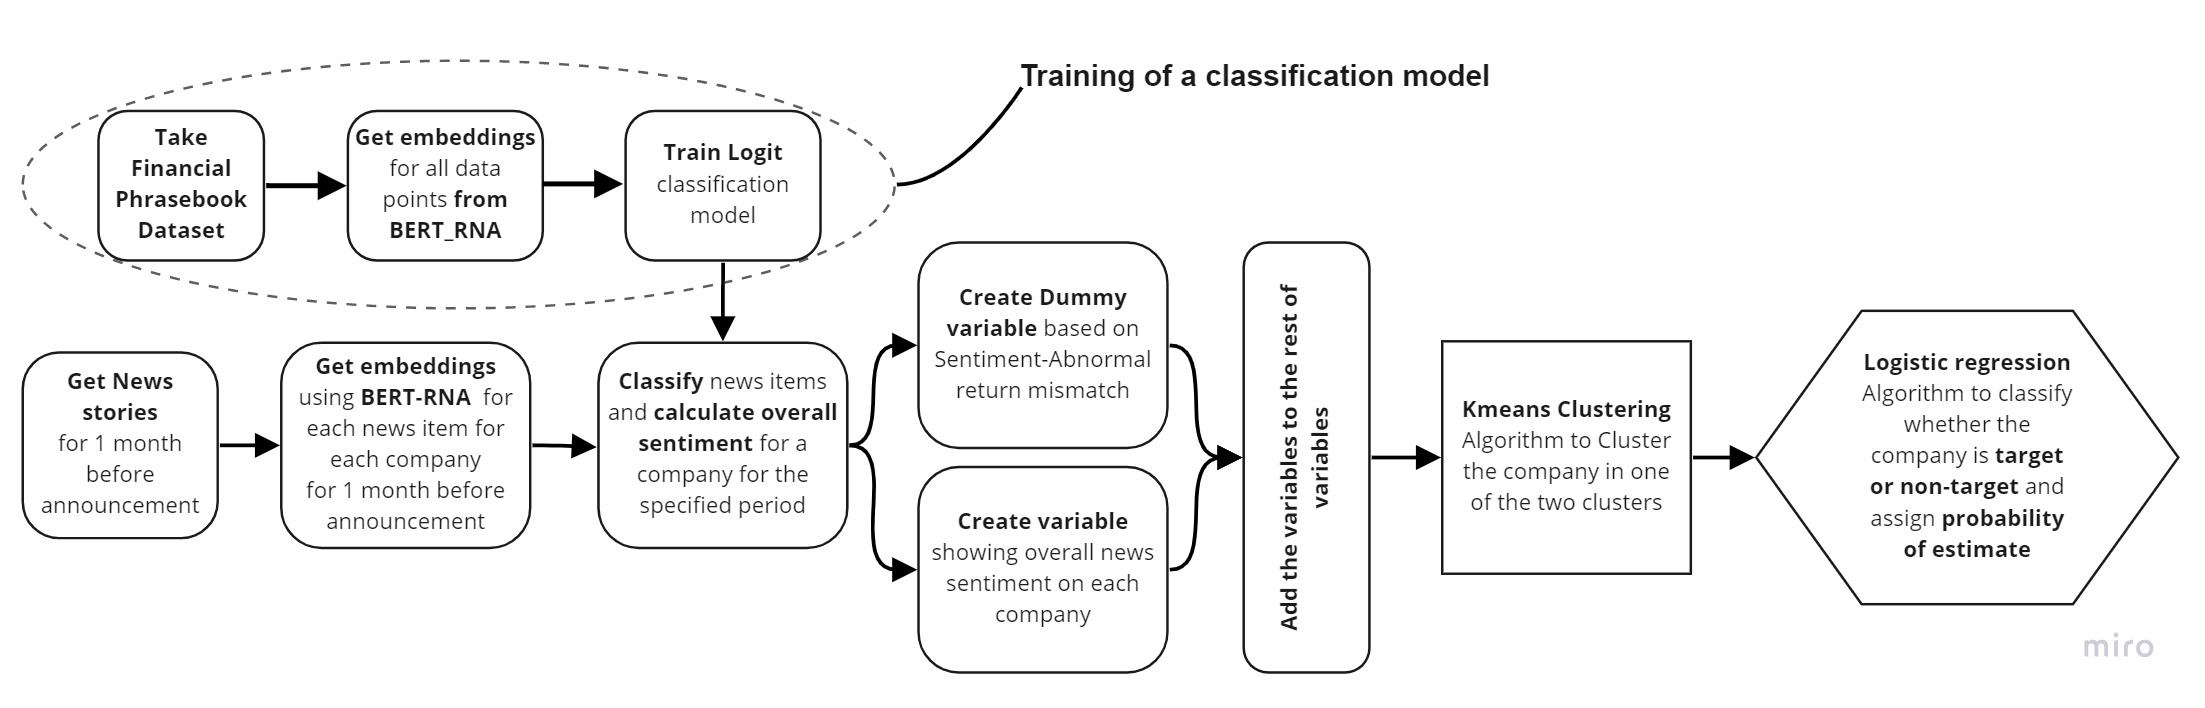

**1. Return-News sentiment mismatch Dummy** – abnormal returns amid no positive news indicate M&A announcement

**2. News Sentiment Score** – News sentiment on a company has a significant impact on target prediction modeling